In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

from vivarium_helpers.id_helper import *

from pathlib import Path

# Add path to vivarium_research_lsff to sys.path so imports will work from sibling folders
import sys, os.path
# Note: Assuming pwd = vivarium_research_lsff/model_updates_2024
vivarium_research_lsff_path = Path(os.path.abspath(".."))
nanosim_models_path = vivarium_research_lsff_path / 'nanosim_models'
print(vivarium_research_lsff_path)
print(nanosim_models_path)
sys.path.append(str(vivarium_research_lsff_path))
sys.path.append(str(nanosim_models_path))
# sys.path.append(f'{vivarium_research_lsff_path}/multiplication_models')

# These require '/mnt/share/homes/ndbs/vivarium_research_lsff/nanosim_models' to be in sys.path
#
# Note: Absolute imports inside these modules don't work unless the directory containing
# the modules is in sys.path, so we can't just add '/mnt/share/homes/ndbs/vivarium_research_lsff'
# to sys.path here and do, e.g., `from nanosim_models import lbwsg`. If we change the
# absolute imports within the modules to relative imports, e.g., `from . import demography`
# instead of `import demography`, then we could do relative imports here. However, I think
# I removed all relative imports from the submodules in order to get the code to run
# when submitting a job to the cluster instead of running interactively, and I don't know
# whether switching back to relative imports will break that functionality.
import lbwsg
import lbwsg_boe # Requires path to vivarium_research_lsff to be in sys.path
import data_processing # Requires path to vivarium_research_lsff to be in sys.path
import lsff_interventions
import demography
import test_lbwsg
import lbwsg_plots
import iron_bw_calc

# This requires '/mnt/share/homes/ndbs/vivarium_research_lsff' to be in sys.path
from multiplication_models import functions_for_all_nutrients as ffan

# Assumes the path to vivarium_research_lsff is in sys.path
# from gbd_data_summary import pull_gbd2019_data as pgd, rank_countries_by_stunting as rbs

!date
!whoami
!uname -a
!pwd
!python --version
!conda info --envs | grep '\*'
!conda list | grep -e pandas -e numpy -e scipy -e matplotlib -e db-queries -e get-draws -e vivarium

/mnt/share/homes/ndbs/vivarium_research_lsff
/mnt/share/homes/ndbs/vivarium_research_lsff/nanosim_models
Wed 17 Jul 2024 05:54:35 AM PDT
ndbs
Linux long-slurm-sarchive-p0004 5.4.0-176-generic #196-Ubuntu SMP Fri Mar 22 16:46:39 UTC 2024 x86_64 x86_64 x86_64 GNU/Linux
/mnt/share/homes/ndbs/vivarium_research_lsff/model_updates_2024
Python 3.8.5
lsff-iron-38          *  /ihme/homes/ndbs/miniconda3/envs/lsff-iron-38
db-queries                23.2.5                   pypi_0    pypi
get-draws                 3.1.1                    pypi_0    pypi
matplotlib                3.3.4                    pypi_0    pypi
numpy                     1.19.5                   pypi_0    pypi
pandas                    1.2.2                    pypi_0    pypi
scipy                     1.6.1                    pypi_0    pypi
vivarium                  0.10.1                   pypi_0    pypi
vivarium-helpers          0.0.11                   pypi_0    pypi
vivarium-public-health    0.10.9                   pypi_

# Goal: Compare relative contributions of different LSFF pathways to DALYs averted

# Create a map of location IDs to locations for our 25 countries

# Find results and define filepaths

In [3]:
results_path = vivarium_research_lsff_path / 'multiplication_models' / 'results_raw'
!ls $results_path

baseline_coverage_data.pkl
baseline_coverage_data_u5.pkl
baseline_coverage_data_wra.pkl
counterfactual_coverage_data.pkl
counterfactual_coverage_data_u5.pkl
counterfactual_coverage_data_wra.pkl
coverage_data_summary.csv
coverage_final.pkl
coverage.pkl
coverage_u5.pkl
coverage_wra.pkl
folic_acid_dalys
folic_acid_in_salt.pkl
folic_acid.pkl
folic_acid_waterfall.pkl
folic_acid_waterfall_salt.pkl
iron_anemia_diff_u5.pkl
iron_anemia_diff_wra.pkl
iron_anemia_wra.pkl
iron_bw_results.csv
iron_bw_results_industry_wheat_2021_04_15.csv
iron_bw_results_zero_2021_04_14.csv
iron_deficiency_difference_u5.pkl
iron_deficiency_difference_wra.pkl
iron_maternal_dalys.pkl
iron_maternal_disorders_wra.pkl
iron_u5_industry_wheat_update.pkl
iron_u5.pkl
iron_wra_industry_wheat_update.pkl
iron_wra.pkl
ntd_birth_prevalence_maize.pkl
ntd_birth_prevalence_wheat.pkl
u5_ira_dalys.pkl
vitamin_a_deficiency_exposure_oil_update.pkl
vitamin_a_deficiency_exposure.pkl
vitamin_a_oil_update.pkl
wra_ira_dalys.pkl
zinc_deficienc

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
# # I think these files are the same as the ones stored in the results directory above
#
# iron_bw_results_path = (
#     nanosim_models_path / 'iron_bw_results_2021_04_09'
#     / 'results' / 'iron_bw_results.csv'
# )
# iron_bw_zero_results_path = (
#     nanosim_models_path / 'iron_bw_results_2021_04_14_zero'
#     / 'results_zero' / 'iron_bw_results_zero_2021_04_14.csv'
# )
# iron_bw_industry_wheat_results_path = (
#     nanosim_models_path / 'iron_bw_results_2021_04_15_industry'
#     / 'results_industry' / 'iron_bw_results_industry_wheat_2021_04_15.csv'
# )

iron_bw_results_path = results_path / 'iron_bw_results.csv'
iron_bw_zero_results_path = results_path / 'iron_bw_results_zero_2021_04_14.csv'
iron_bw_industry_wheat_results_path = results_path / 'iron_bw_results_industry_wheat_2021_04_15.csv'

iron_u5_results_path = results_path / 'iron_u5.pkl'
iron_u5_industry_wheat_results_path = results_path / 'iron_u5_industry_wheat_update.pkl'
iron_wra_results_path = results_path / 'iron_wra.pkl'
iron_wra_industry_wheat_results_path = results_path / 'iron_wra_industry_wheat_update.pkl'

iron_maternal_disorders_wra_path = results_path / 'iron_maternal_disorders_wra.pkl'

folic_acid_results_path = results_path / 'folic_acid.pkl'
folic_acid_in_salt_results_path = results_path / 'folic_acid_in_salt.pkl'

zinc_results_path = results_path / 'zinc.pkl'
vitamin_a_oil_results_path = results_path / 'vitamin_a_oil_update.pkl'

# See what some results look like

Different files have different formats, so we'll standardize them below.

In [5]:
df = pd.read_pickle(results_path / 'iron_u5_industry_wheat_update.pkl')
df

draw,location_id,coverage_level,year,vehicle,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,...,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999,measure
0,6,0.2,2025,industry wheat,3.214088,1.118524,1.684095,0.965343,3.480620,2.737738,...,1.596346,3.621688,4.199178,1.072679,2.307565,6.923879,1.537115,2.053347,1.829435,pif
1,6,0.5,2025,industry wheat,7.777186,2.762206,4.151225,2.389536,8.452598,6.670246,...,3.923702,8.719056,10.117121,2.654606,5.649876,16.761471,3.801178,5.047455,4.518938,pif
2,6,0.8,2025,industry wheat,12.048928,4.365913,6.549429,3.785649,13.141853,10.403356,...,6.173010,13.442606,15.608101,4.204651,8.854652,25.981634,6.016235,7.941823,7.144208,pif
3,6,1.0,2025,industry wheat,14.744571,5.413359,8.110969,4.701071,16.119469,12.786432,...,7.630569,16.398815,19.047411,5.220647,10.917632,31.806669,7.466224,9.817803,8.859441,pif
4,6,0.2,2025,zero industry wheat,-0.444387,-0.140759,-0.246195,-0.139023,-0.576749,-0.433155,...,-0.251820,-0.590484,-0.639088,-0.131144,-0.353225,-1.175903,-0.191889,-0.329320,-0.275872,pif
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,522,1.0,2025,industry wheat,257.005440,137.978019,118.841408,111.666940,242.552024,236.646736,...,117.002905,260.784254,308.463213,146.792945,197.258925,267.463796,171.493759,123.774497,101.862440,rates_averted
596,522,0.2,2025,zero industry wheat,-4.164923,-2.639730,-2.066579,-2.200436,-5.487101,-4.803434,...,-1.935714,-4.176262,-5.166152,-3.297371,-3.650168,-5.689624,-3.683392,-2.547710,-1.430041,rates_averted
597,522,0.5,2025,zero industry wheat,-10.432208,-6.607059,-5.170541,-5.505601,-13.749180,-12.030521,...,-4.843584,-10.457141,-12.939733,-8.254199,-9.137238,-14.254726,-9.220370,-6.377359,-3.576869,rates_averted
598,522,0.8,2025,zero industry wheat,-16.723388,-10.583670,-8.279414,-8.816180,-22.048993,-19.283938,...,-7.756615,-16.757803,-20.742538,-13.223954,-14.638492,-22.856634,-14.771614,-10.216715,-5.725816,rates_averted


In [6]:
df.vehicle.unique()

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['industry wheat', 'zero industry wheat'], dtype=object)

In [7]:
df = pd.read_pickle(iron_u5_results_path)
df

draw,location_id,coverage_level,year,vehicle,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,...,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999,measure
0,6,0.2,2025,industry wheat,6.394933,2.343036,3.264021,1.889394,6.099295,5.016220,...,2.930081,6.472833,7.909899,2.277403,4.335902,11.760010,3.233146,3.712411,3.475743,pif
1,6,0.5,2025,industry wheat,14.975322,5.708617,7.939372,4.632439,14.489039,11.959095,...,7.099944,15.122566,18.435089,5.571873,10.421399,27.831902,7.899147,9.001633,8.492461,pif
2,6,0.8,2025,industry wheat,22.484278,8.904114,12.363614,7.270039,22.053413,18.262833,...,11.015200,22.661122,27.552965,8.726392,16.040117,42.217856,12.353355,13.975274,13.282175,pif
3,6,1.0,2025,industry wheat,26.966619,10.944587,15.180889,8.971922,26.681654,22.140738,...,13.492242,27.148930,32.949893,10.754880,19.545161,50.970627,15.209854,17.126090,16.354219,pif
4,6,0.2,2025,wheat flour,3.221340,1.037210,1.808838,1.025055,4.172969,3.147165,...,1.843748,4.241484,4.604619,0.967990,2.579024,8.475886,1.415439,2.410672,2.029698,pif
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1591,522,1.0,2025,zero maize flour,-10.690245,-12.057816,-7.551882,-8.761066,-14.600126,-14.848382,...,-11.950550,-16.220443,-37.191927,-9.918560,-12.999156,-30.457278,-18.601387,-8.507799,-7.963798,rates_averted
1592,522,0.2,2025,zero wheat flour,-4.164923,-2.639730,-2.066579,-2.200436,-5.487101,-4.803434,...,-1.935714,-4.176262,-5.166152,-3.297371,-3.650168,-5.689624,-3.683392,-2.547710,-1.430041,rates_averted
1593,522,0.5,2025,zero wheat flour,-10.432208,-6.607059,-5.170541,-5.505601,-13.749180,-12.030521,...,-4.843584,-10.457141,-12.939733,-8.254199,-9.137238,-14.254726,-9.220370,-6.377359,-3.576869,rates_averted
1594,522,0.8,2025,zero wheat flour,-16.723388,-10.583670,-8.279414,-8.816180,-22.048993,-19.283938,...,-7.756615,-16.757803,-20.742538,-13.223954,-14.638492,-22.856634,-14.771614,-10.216715,-5.725816,rates_averted


In [8]:
df.columns.difference(df.filter(like='draw').columns)

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['coverage_level', 'location_id', 'measure', 'vehicle', 'year'], dtype='object', name='draw')

In [9]:
pd.read_pickle(results_path / 'iron_maternal_disorders_wra.pkl')

draw_0  \
location_id vehicle             coverage_level year   measure                       
6           industry wheat      0.2            2025.0 pif                6.899405   
                                0.5            2025.0 pif               17.147234   
                                0.8            2025.0 pif               27.274799   
                                1.0            2025.0 pif               33.960393   
            zero industry wheat 0.2            2025.0 pif               -0.934570   
...                                                                           ...   
522         industry wheat      1.0            2025.0 counts_averted  1435.211189   
            zero industry wheat 0.2            2025.0 counts_averted   -21.974793   
                                0.5            2025.0 counts_averted   -54.977228   
                                0.8            2025.0 counts_averted   -88.028020   
                                1.0            2025.0 counts_averted  -110.088783   

                                                                          draw_1  \
location_id vehicle             coverage_level year   measure                      
6           industry wheat      0.2            2025.0 pif               2.518234   
                                0.5            2025.0 pif               6.274608   
                                0.8            2025.0 pif              10.005957   
                                1.0            2025.0 pif              12.479703   
            zero industry wheat 0.2            2025.0 pif              -0.314777   
...                                                                          ...   
522         industry wheat      1.0            2025.0 counts_averted  914.846812   
            zero industry wheat 0.2            2025.0 counts_averted  -17.178226   
                                0.5            2025.0 counts_averted  -42.975287   
                                0.8            2025.0 counts_averted  -68.808060   
                                1.0            2025.0 counts_averted  -86.049772   

                                                                         draw_10  \
location_id vehicle             coverage_level year   measure                      
6           industry wheat      0.2            2025.0 pif               3.060155   
                                0.5            2025.0 pif               7.624010   
                                0.8            2025.0 pif              12.156407   
                                1.0            2025.0 pif              15.160634   
            zero industry wheat 0.2            2025.0 pif              -0.443709   
...                                                                          ...   
522         industry wheat      1.0            2025.0 counts_averted  854.686050   
            zero industry wheat 0.2            2025.0 counts_averted  -14.679806   
                                0.5            2025.0 counts_averted  -36.717758   
                                0.8            2025.0 counts_averted  -58.777622   
                                1.0            2025.0 counts_averted  -73.496382   

                                                                         draw_100  \
location_id vehicle             coverage_level year   measure                       
6           industry wheat      0.2            2025.0 pif                2.169169   
                                0.5            2025.0 pif                5.407089   
                                0.8            2025.0 pif                8.626107   
                                1.0            2025.0 pif               10.761673   
            zero industry wheat 0.2            2025.0 pif               -0.310723   
...                                                                           ...   
522         industry wheat      1.0            2025.0 counts_averted  1199.434005   
            zero i

# Load data, standardize format, and combine into single dataframe

In [10]:
%%time

def quadruplicate_draws(df):
    """Repeat each draw column in df 4 times to get all 1000 draws
    instead of only 250, filling in draw numbers based on which
    draws are missing.
    Assumes df has 250 arbitrarily chosen (e.g., random) draws
    between draw_0 and draw_999, as in iron_bw_results.csv,
    and returns a DataFrame in which all columns draw_0, ..., draw_999
    are present, but not necessarily in order.
    """
    draw_cols = df.filter(like='draw_').columns
    missing_draws = pd.Index(
        [f'draw_{n}' for n in range(1000)]).difference(draw_cols)
    draw_data = df[draw_cols]
    new_draw_data = pd.concat([draw_data] * 3, axis=1)
    new_draw_data.columns = missing_draws
    return pd.concat([df, new_draw_data], axis=1)

def draw_number_or_negative_one(columns):
    """Replaces column names of the form 'draw_X' with the integer X,
    and replaces other column names with -1. This is a vectorized key
    function to sort columns by putting all non-draw columns before
    draw columns, and sort draw columns numerically.
    """
    is_draw = columns.str.fullmatch(r'draw_\d{1,3}')
    column_sort_keys = np.where(is_draw, columns.str[5:], -1).astype(int)
    return column_sort_keys

iron_bw_results = (
    pd.concat([
        pd.read_csv(iron_bw_results_path),
        pd.read_csv(iron_bw_zero_results_path),
        pd.read_csv(iron_bw_industry_wheat_results_path),
    ], ignore_index=True)
    .pipe(quadruplicate_draws)
    .assign(year=2025, nutrient='iron', age_group='u5',
            cause='low_birthweight')
)

iron_anemia_u5_results = (
    pd.concat([
        pd.read_pickle(iron_u5_results_path),
        pd.read_pickle(iron_u5_industry_wheat_results_path),
    ], ignore_index=True)
    .assign(nutrient='iron', age_group='u5', cause='anemia')
)

iron_anemia_wra_results = (
    pd.concat([
        pd.read_pickle(iron_wra_results_path),
        pd.read_pickle(iron_wra_industry_wheat_results_path),
    ], ignore_index=True)
    .assign(nutrient='iron', age_group='wra', cause='anemia')
)

iron_maternal_disorders_results = (
    pd.read_pickle(iron_maternal_disorders_wra_path)
    .reset_index()
    .assign(year=lambda df: df['year'].astype(int))
    .assign(nutrient='iron', age_group='wra', cause='maternal_disorders')
)

folic_acid_results = (
    pd.concat([
        pd.read_pickle(folic_acid_results_path),
        pd.read_pickle(
            folic_acid_in_salt_results_path
        ).assign(nutrient='folic acid', vehicle='salt'),
    ], ignore_index=True)
    .rename(columns={'year_id': 'year'})
    .assign(age_group='u5', cause='neural_tube_defects')
)

zinc_results = (
    pd.read_pickle(zinc_results_path)
    .assign(nutrient='zinc', age_group='u5', cause='diarrheal_diseases')
)

vitamin_a_oil_results = (
    pd.read_pickle(vitamin_a_oil_results_path)
    .assign(nutrient = 'vitamin a', age_group='u5',
            cause='vad|dd|measles')
)

# Combine all results in to one DataFrame - columns will be sorted
# according to the column order of the first df in the list
results = pd.concat([
    # Sort columns of first dataframe to concat so others
    # will be automatically aligned
    iron_bw_results.sort_index(axis=1, key=draw_number_or_negative_one),
    iron_anemia_u5_results,
    iron_anemia_wra_results,
    iron_maternal_disorders_results,
    folic_acid_results,
    zinc_results,
    vitamin_a_oil_results
], ignore_index=True)

results

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 295 ms, sys: 245 ms, total: 540 ms
Wall time: 543 ms


,coverage_level,nutrient,year,age_group,cause,location_id,vehicle,measure,draw_0,draw_1,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
0,0.2,iron,2025,u5,low_birthweight,6,wheat flour,counts_averted,2904.543372,3749.252406,...,4450.653495,3373.314205,2202.609063,3980.202743,1817.149521,1443.065174,2202.609063,1817.149521,3654.702138,3654.702138
1,0.2,iron,2025,u5,low_birthweight,11,wheat flour,counts_averted,0.410664,55.025127,...,55.307435,68.835866,318.490189,36.359475,87.106196,130.843194,318.490189,87.106196,30.681769,30.681769
2,0.2,iron,2025,u5,low_birthweight,15,wheat flour,counts_averted,22.630438,39.480737,...,75.879004,24.705208,51.528323,29.401829,10.900119,44.477208,51.528323,10.900119,84.762431,84.762431
3,0.2,iron,2025,u5,low_birthweight,20,wheat flour,counts_averted,40.655603,36.804245,...,98.195414,33.785295,30.470178,13.679045,24.439117,21.388484,30.470178,24.439117,36.171505,36.171505
4,0.2,iron,2025,u5,low_birthweight,141,maize flour,counts_averted,366.596716,698.946383,...,1083.183300,892.482109,458.504144,384.333877,454.108400,923.678018,458.504144,454.108400,385.494035,385.494035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22072,1.0,vitamin a,2025,u5,vad|dd|measles,522,zero industry oil,rates_averted,-280.528083,-170.432398,...,-100.707815,-120.156925,-432.523437,-446.087736,-199.101797,-156.058629,-156.080886,-132.122548,-127.778290,-57.591651
22073,0.2,vitamin a,2025,u5,vad|dd|measles,522,zero oil,rates_averted,-56.105617,-34.086480,...,-20.141563,-24.031385,-86.504687,-89.217547,-39.820359,-31.211726,-31.216177,-26.424510,-25.555658,-11.518330
22074,0.5,vitamin a,2025,u5,vad|dd|measles,522,zero oil,rates_averted,-140.264041,-85.216199,...,-50.353908,-60.078463,-216.261718,-223.043868,-99.550899,-78.029315,-78.040443,-66.061274,-63.889145,-28.795826
22075,0.8,vitamin a,2025,u5,vad|dd|measles,522,zero oil,rates_averted,-224.422466,-136.345918,...,-80.566252,-96.125540,-346.018749,-356.870189,-159.281438,-124.846903,-124.864709,-105.698039,-102.222632,-46.073321


In [11]:
results.coverage_level.unique()

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([0.2, 0.5, 0.8, nan, 1. ])

# Get lists of coverage levels for all interventions

In [12]:
all_interventions = results.groupby(['age_group', 'vehicle', 'nutrient', 'cause'])['coverage_level'].unique()
all_interventions

age_group  vehicle              nutrient    cause              
u5         industry oil         vitamin a   vad|dd|measles         [0.2, 0.5, 0.8, 1.0]
           industry wheat       iron        anemia                 [0.2, 0.5, 0.8, 1.0]
                                            low_birthweight             [0.2, 0.5, 0.8]
                                zinc        diarrheal_diseases     [0.2, 0.5, 0.8, 1.0]
           maize flour          folic acid  neural_tube_defects         [0.2, 0.5, 0.8]
                                iron        anemia                 [0.2, 0.5, 0.8, 1.0]
                                            low_birthweight             [0.2, 0.5, 0.8]
                                zinc        diarrheal_diseases     [0.2, 0.5, 0.8, 1.0]
           oil                  vitamin a   vad|dd|measles         [0.2, 0.5, 0.8, 1.0]
           salt                 folic acid  neural_tube_defects         [0.2, 0.5, 0.8]
           wheat flour          folic acid  neural_tube_

# Define draw columns and non-draw columns

In [13]:
draw_cols = results.filter(like='draw').columns
non_draw_cols = results.columns.difference(draw_cols)
print(len(draw_cols))
non_draw_cols

1000


Index(['age_group', 'cause', 'coverage_level', 'location_id', 'measure',
       'nutrient', 'vehicle', 'year'],
      dtype='object')

# Investigate missing data

For some reason, some draws of zinc estimates are missing.

Also, `coverage_level` is missing for all "zero" vehicles in the iron-birthweight results that I generated because the gap coverage level is undefined for this scenario. (Well, maybe it should be the negative of the baseline coverage level, since baseline gap coverage is defined to be zero, but that level would be different for each country and vehicle.)

I would think the "zero" fortification scenario should have undefined or negative `coverage_level` for the other nutrient/outcome results as well, but it looks like people ran these with varying coverage levels, with different results, so I'm not sure what that means...

In [14]:
# Why is draw_1 missing for some rows of zinc results???
zinc_results.loc[zinc_results.draw_1.isna()]

draws,location_id,year,vehicle,coverage_level,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,...,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999,measure,nutrient,age_group,cause
0,6,2021,industry wheat,0.2,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,pif,zinc,u5,diarrheal_diseases
1,6,2021,industry wheat,0.5,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,pif,zinc,u5,diarrheal_diseases
2,6,2021,industry wheat,0.8,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,pif,zinc,u5,diarrheal_diseases
3,6,2021,industry wheat,1.0,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,pif,zinc,u5,diarrheal_diseases
4,6,2021,wheat flour,0.2,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,pif,zinc,u5,diarrheal_diseases
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2295,207,2025,zero maize flour,1.0,-1.856662,NaN,-3.389087,-3.040399,-2.053151,-2.148667,...,-2.450738,-2.796514,-2.643430,-2.377580,-2.333018,-1.742294,pif,zinc,u5,diarrheal_diseases
2296,207,2025,zero wheat flour,0.2,-1.576930,NaN,-2.314869,-2.538349,-1.573692,-1.824356,...,-1.983594,-1.421363,-2.088902,-2.433369,-0.532471,-3.432688,pif,zinc,u5,diarrheal_diseases
2297,207,2025,zero wheat flour,0.5,-3.942324,NaN,-5.787172,-6.345873,-3.934230,-4.560891,...,-4.958985,-3.553408,-5.222254,-6.083422,-1.331178,-8.581720,pif,zinc,u5,diarrheal_diseases
2298,207,2025,zero wheat flour,0.8,-6.307719,NaN,-9.259475,-10.153397,-6.294769,-7.297425,...,-7.934377,-5.685453,-8.355607,-9.733475,-2.129885,-13.730752,pif,zinc,u5,diarrheal_diseases


In [15]:
results.columns[results.isna().any()]

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['coverage_level', 'draw_1', 'draw_60', 'draw_61', 'draw_78', 'draw_85',
       'draw_136', 'draw_138', 'draw_145', 'draw_148', 'draw_149', 'draw_151',
       'draw_157', 'draw_195', 'draw_200', 'draw_202', 'draw_210', 'draw_212',
       'draw_213', 'draw_222', 'draw_223', 'draw_231', 'draw_236', 'draw_243',
       'draw_254', 'draw_267', 'draw_271', 'draw_289', 'draw_314', 'draw_319',
       'draw_325', 'draw_338', 'draw_342', 'draw_351', 'draw_354', 'draw_370',
       'draw_372', 'draw_391', 'draw_397', 'draw_402', 'draw_415', 'draw_436',
       'draw_439', 'draw_441', 'draw_484', 'draw_490', 'draw_505', 'draw_508',
       'draw_519', 'draw_540', 'draw_545', 'draw_586', 'draw_589', 'draw_606',
       'draw_609', 'draw_628', 'draw_629', 'draw_643', 'draw_682', 'draw_704',
       'draw_728', 'draw_741', 'draw_743', 'draw_747', 'draw_774', 'draw_786',
       'draw_793', 'draw_801', 'draw_813', 'draw_832', 'draw_838', 'draw_840',
       'draw_844', 'draw_854', 'draw_855', 'draw_860

In [16]:
# Number of rows missing for each draw
n_missing = results.isna().sum()
n_missing[n_missing>0]

coverage_level     126
draw_1             640
draw_60            520
draw_61            200
draw_78           1080
                  ... 
draw_939           240
draw_942           360
draw_945           680
draw_960           120
draw_966           240
Length: 91, dtype: int64

In [17]:
# Number of draws missing a given number of values:
# Most (917) draws are missing in 0 rows, 11 draws are missing in 440 rows,
# and 7 or fewer draws are missing in some other number of rows,
# ranging from 80 to 2200 (there are 28 distinct values for the number of
# rows missing, including 0).
n_missing.value_counts()

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0       917
440      11
120       7
80        6
240       6
640       6
320       6
760       5
680       5
1960      4
560       4
1760      3
360       3
1640      3
520       2
880       2
1440      2
1520      2
1080      2
1400      2
1280      2
200       2
1560      1
1240      1
1200      1
2200      1
126       1
1000      1
dtype: int64

In [18]:
n_missing.max()

2200

In [19]:
n_missing.nunique()

28

In [20]:
# Number of rows missing 'coverage_level' for each (nutrient, vehicle, cause triple)
results.loc[results.coverage_level.isna(), ['nutrient', 'vehicle', 'cause']].value_counts()

nutrient  vehicle           cause          
iron      zero wheat flour  low_birthweight    75
          zero maize flour  low_birthweight    51
dtype: int64

In [21]:
# Number of missing draws for each (nutrient, vehicle, cause) triple,
# i.e., the number of columns missing for each row.
# The fact that only zinc has missing draws, and there are always either
# 400 or 300 draws missing for a given vehicle seems like much more
# of a pattern than the number of rows missing for each draw counted above.
results.loc[results[draw_cols].isna().any(axis=1), ['nutrient', 'vehicle', 'cause']].value_counts()

nutrient  vehicle              cause             
zinc      industry wheat       diarrheal_diseases    400
          wheat flour          diarrheal_diseases    400
          zero industry wheat  diarrheal_diseases    400
          zero wheat flour     diarrheal_diseases    400
          maize flour          diarrheal_diseases    300
          zero maize flour     diarrheal_diseases    300
dtype: int64

In [22]:
# What do these results mean for different coverage levels???
results.loc[results.vehicle.str.contains('zero') & results.coverage_level.isin([0.2, 0.5, 0.8, 1.0])]

,coverage_level,nutrient,year,age_group,cause,location_id,vehicle,measure,draw_0,draw_1,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
737,0.2,iron,2025,u5,anemia,6,zero industry wheat,pif,-0.444387,-0.140759,...,-0.336021,-0.251820,-0.590484,-0.639088,-0.131144,-0.353225,-1.175903,-0.191889,-0.329320,-0.275872
738,0.5,iron,2025,u5,anemia,6,zero industry wheat,pif,-1.115948,-0.352441,...,-0.841974,-0.631231,-1.485244,-1.606627,-0.328267,-0.885867,-2.955786,-0.480372,-0.825526,-0.690926
739,0.8,iron,2025,u5,anemia,6,zero industry wheat,pif,-1.793535,-0.564776,...,-1.350240,-1.012669,-2.390972,-2.584962,-0.525878,-1.421894,-4.755102,-0.769636,-1.324418,-1.107479
740,1.0,iron,2025,u5,anemia,6,zero industry wheat,pif,-2.248634,-0.706696,...,-1.690374,-1.268094,-3.000952,-3.243242,-0.657892,-1.781136,-5.965556,-0.962914,-1.658511,-1.386016
741,0.2,iron,2025,u5,anemia,6,zero wheat flour,pif,-0.444387,-0.140759,...,-0.336021,-0.251820,-0.590484,-0.639088,-0.131144,-0.353225,-1.175903,-0.191889,-0.329320,-0.275872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22072,1.0,vitamin a,2025,u5,vad|dd|measles,522,zero industry oil,rates_averted,-280.528083,-170.432398,...,-100.707815,-120.156925,-432.523437,-446.087736,-199.101797,-156.058629,-156.080886,-132.122548,-127.778290,-57.591651
22073,0.2,vitamin a,2025,u5,vad|dd|measles,522,zero oil,rates_averted,-56.105617,-34.086480,...,-20.141563,-24.031385,-86.504687,-89.217547,-39.820359,-31.211726,-31.216177,-26.424510,-25.555658,-11.518330
22074,0.5,vitamin a,2025,u5,vad|dd|measles,522,zero oil,rates_averted,-140.264041,-85.216199,...,-50.353908,-60.078463,-216.261718,-223.043868,-99.550899,-78.029315,-78.040443,-66.061274,-63.889145,-28.795826
22075,0.8,vitamin a,2025,u5,vad|dd|measles,522,zero oil,rates_averted,-224.422466,-136.345918,...,-80.566252,-96.125540,-346.018749,-356.870189,-159.281438,-124.846903,-124.864709,-105.698039,-102.222632,-46.073321


# View some of the results

In [23]:
vitamin_a_oil_results

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


draws,location_id,year,vehicle,coverage_level,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,...,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999,measure,nutrient,age_group,cause
0,6,2021,industry oil,0.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,pif,vitamin a,u5,vad|dd|measles
1,6,2021,industry oil,0.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,pif,vitamin a,u5,vad|dd|measles
2,6,2021,industry oil,0.8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,pif,vitamin a,u5,vad|dd|measles
3,6,2021,industry oil,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,pif,vitamin a,u5,vad|dd|measles
4,6,2021,oil,0.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,pif,vitamin a,u5,vad|dd|measles
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,522,2025,zero industry oil,1.0,-280.528083,-170.432398,-67.713936,-141.871553,-109.929708,-127.545535,...,-199.101797,-156.058629,-156.080886,-132.122548,-127.778290,-57.591651,rates_averted,vitamin a,u5,vad|dd|measles
5996,522,2025,zero oil,0.2,-56.105617,-34.086480,-13.542787,-28.374311,-21.985942,-25.509107,...,-39.820359,-31.211726,-31.216177,-26.424510,-25.555658,-11.518330,rates_averted,vitamin a,u5,vad|dd|measles
5997,522,2025,zero oil,0.5,-140.264041,-85.216199,-33.856968,-70.935776,-54.964854,-63.772768,...,-99.550899,-78.029315,-78.040443,-66.061274,-63.889145,-28.795826,rates_averted,vitamin a,u5,vad|dd|measles
5998,522,2025,zero oil,0.8,-224.422466,-136.345918,-54.171149,-113.497242,-87.943767,-102.036428,...,-159.281438,-124.846903,-124.864709,-105.698039,-102.222632,-46.073321,rates_averted,vitamin a,u5,vad|dd|measles


In [24]:
folic_acid_results

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,coverage_level,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,draw_103,draw_104,draw_105,...,draw_997,draw_998,draw_999,location_id,measure,nutrient,vehicle,year,age_group,cause
0,0.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,141,counts_averted,folic acid,maize flour,2022,u5,neural_tube_defects
1,0.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,141,counts_averted,folic acid,maize flour,2022,u5,neural_tube_defects
2,0.8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,141,counts_averted,folic acid,maize flour,2022,u5,neural_tube_defects
3,0.2,462.764918,792.327297,1385.927866,834.969291,385.018803,561.746514,309.268440,417.987375,652.753961,...,715.173987,1221.131607,972.358414,141,counts_averted,folic acid,maize flour,2023,u5,neural_tube_defects
4,0.5,1156.912294,1980.818242,3464.819665,2087.423228,962.547006,1404.366284,773.171100,1044.968437,1631.884901,...,1787.934967,3052.829017,2430.896036,141,counts_averted,folic acid,maize flour,2023,u5,neural_tube_defects
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2371,0.5,13.617160,9.731125,10.756299,11.107827,12.788527,11.413729,8.301865,11.727983,10.479429,...,10.189048,10.474902,9.768711,522,pif,folic acid,salt,2024,u5,neural_tube_defects
2372,0.8,21.787456,15.569801,17.210078,17.772523,20.461644,18.261966,13.282985,18.764772,16.767087,...,16.302477,16.759843,15.629938,522,pif,folic acid,salt,2024,u5,neural_tube_defects
2373,0.2,5.645665,4.109396,4.444850,4.538806,5.248097,4.773042,3.501700,4.891810,4.349247,...,4.254502,4.345539,4.094821,522,pif,folic acid,salt,2025,u5,neural_tube_defects
2374,0.5,14.114163,10.273491,11.112126,11.347014,13.120243,11.932605,8.754250,12.229525,10.873118,...,10.636254,10.863848,10.237052,522,pif,folic acid,salt,2025,u5,neural_tube_defects


In [25]:
iron_bw_results

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,coverage_level,location_id,measure,vehicle,draw_4,draw_6,draw_10,draw_13,draw_16,draw_18,...,draw_991,draw_993,draw_995,draw_996,draw_997,draw_998,year,nutrient,age_group,cause
0,0.2,6,counts_averted,wheat flour,2904.543372,3749.252406,5431.758587,4862.595241,6909.634628,917.572898,...,3373.314205,3980.202743,1443.065174,2202.609063,1817.149521,3654.702138,2025,iron,u5,low_birthweight
1,0.2,11,counts_averted,wheat flour,0.410664,55.025127,205.150746,4.903218,147.438639,166.470581,...,68.835866,36.359475,130.843194,318.490189,87.106196,30.681769,2025,iron,u5,low_birthweight
2,0.2,15,counts_averted,wheat flour,22.630438,39.480737,83.344657,17.356558,85.796009,25.949345,...,24.705208,29.401829,44.477208,51.528323,10.900119,84.762431,2025,iron,u5,low_birthweight
3,0.2,20,counts_averted,wheat flour,40.655603,36.804245,51.674548,65.486548,63.615450,3.636705,...,33.785295,13.679045,21.388484,30.470178,24.439117,36.171505,2025,iron,u5,low_birthweight
4,0.2,141,counts_averted,maize flour,366.596716,698.946383,2010.007523,146.087604,643.183569,472.132097,...,892.482109,384.333877,923.678018,458.504144,454.108400,385.494035,2025,iron,u5,low_birthweight
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724,0.8,205,rates_averted,industry wheat,59.528647,55.773880,88.919154,45.026796,71.456239,45.480074,...,26.834326,40.132145,39.019372,41.920770,29.621782,45.329931,2025,iron,u5,low_birthweight
725,0.8,207,rates_averted,industry wheat,54.026166,44.765797,88.419557,36.687449,90.741135,36.755877,...,29.503029,46.354618,48.441216,47.919987,37.791424,57.586888,2025,iron,u5,low_birthweight
726,0.8,213,rates_averted,industry wheat,3.249961,7.724693,9.394378,0.103529,7.342507,1.717634,...,2.282903,1.221058,6.021455,1.220704,2.226723,4.207150,2025,iron,u5,low_birthweight
727,0.8,214,rates_averted,industry wheat,72.021435,87.463847,100.072021,81.552452,87.795475,27.392393,...,39.682584,51.001220,28.891231,37.467753,29.566657,57.113159,2025,iron,u5,low_birthweight


# Tabulate some results

In [26]:
iron_u5_results = results.query("nutrient == 'iron' and age_group == 'u5'")
iron_u5_results

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,coverage_level,nutrient,year,age_group,cause,location_id,vehicle,measure,draw_0,draw_1,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
0,0.2,iron,2025,u5,low_birthweight,6,wheat flour,counts_averted,2904.543372,3749.252406,...,4450.653495,3373.314205,2202.609063,3980.202743,1817.149521,1443.065174,2202.609063,1817.149521,3654.702138,3654.702138
1,0.2,iron,2025,u5,low_birthweight,11,wheat flour,counts_averted,0.410664,55.025127,...,55.307435,68.835866,318.490189,36.359475,87.106196,130.843194,318.490189,87.106196,30.681769,30.681769
2,0.2,iron,2025,u5,low_birthweight,15,wheat flour,counts_averted,22.630438,39.480737,...,75.879004,24.705208,51.528323,29.401829,10.900119,44.477208,51.528323,10.900119,84.762431,84.762431
3,0.2,iron,2025,u5,low_birthweight,20,wheat flour,counts_averted,40.655603,36.804245,...,98.195414,33.785295,30.470178,13.679045,24.439117,21.388484,30.470178,24.439117,36.171505,36.171505
4,0.2,iron,2025,u5,low_birthweight,141,maize flour,counts_averted,366.596716,698.946383,...,1083.183300,892.482109,458.504144,384.333877,454.108400,923.678018,458.504144,454.108400,385.494035,385.494035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2920,1.0,iron,2025,u5,anemia,522,industry wheat,rates_averted,257.005440,137.978019,...,187.570237,117.002905,260.784254,308.463213,146.792945,197.258925,267.463796,171.493759,123.774497,101.862440
2921,0.2,iron,2025,u5,anemia,522,zero industry wheat,rates_averted,-4.164923,-2.639730,...,-3.504850,-1.935714,-4.176262,-5.166152,-3.297371,-3.650168,-5.689624,-3.683392,-2.547710,-1.430041
2922,0.5,iron,2025,u5,anemia,522,zero industry wheat,rates_averted,-10.432208,-6.607059,...,-8.771786,-4.843584,-10.457141,-12.939733,-8.254199,-9.137238,-14.254726,-9.220370,-6.377359,-3.576869
2923,0.8,iron,2025,u5,anemia,522,zero industry wheat,rates_averted,-16.723388,-10.583670,...,-14.050315,-7.756615,-16.757803,-20.742538,-13.223954,-14.638492,-22.856634,-14.771614,-10.216715,-5.725816


In [27]:
iron_u5_results.vehicle.unique()

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['wheat flour', 'maize flour', 'zero wheat flour',
       'zero maize flour', 'industry wheat', 'zero industry wheat'],
      dtype=object)

In [28]:
iron_u5_results.query("vehicle == 'wheat flour' and coverage_level == 0.2").groupby(['cause', 'measure'])[draw_cols].sum().T.describe()

cause           anemia                            low_birthweight  \
measure counts_averted          pif rates_averted  counts_averted   
count      1000.000000  1000.000000   1000.000000     1000.000000   
mean      35717.428198    24.006126    270.232860    72852.546945   
std       18581.553739    13.734622    140.236159    25745.928914   
min      -24114.771319   -14.991737   -171.382978    15099.332326   
25%       23614.391475    15.015408    178.422312    54278.684253   
50%       35404.683270    22.757061    269.079736    71220.297762   
75%       48668.239566    32.990815    366.899842    87027.251150   
max       93016.543772    96.594175    735.917213   165626.676595   

cause                               
measure          pif rates_averted  
count    1000.000000   1000.000000  
mean        1.958956    451.097075  
std         0.700453    153.545832  
min         0.291071     83.304595  
25%         1.460839    341.345635  
50%         1.913983    437.164389  
75%         2.380442    533.469176  
max         4.519313    931.461673

In [29]:
iron_u5_results.year.unique()

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([2025])

In [30]:
iron_bw_results.vehicle.unique()

array(['wheat flour', 'maize flour', 'zero wheat flour',
       'zero maize flour', 'industry wheat'], dtype=object)

In [31]:
iron_bw_results.query("vehicle == 'zero wheat flour'")

,coverage_level,location_id,measure,vehicle,draw_4,draw_6,draw_10,draw_13,draw_16,draw_18,...,draw_991,draw_993,draw_995,draw_996,draw_997,draw_998,year,nutrient,age_group,cause
378,NaN,11,counts_averted,zero wheat flour,-2149.994036,-2256.608589,-3501.806655,-1577.283585,-1861.840588,-1730.630493,...,-866.992632,-1808.426230,-1862.415065,-1219.319275,-1012.598364,-1851.865508,2025,iron,u5,low_birthweight
379,NaN,163,counts_averted,zero wheat flour,-8055.341252,-11351.262143,-10692.441877,-9390.793361,-9035.794431,-6273.328573,...,-4456.036608,-6016.544034,-4334.351936,-4831.800010,-4060.728998,-5072.691423,2025,iron,u5,low_birthweight
380,NaN,205,counts_averted,zero wheat flour,-310.695766,-341.222169,-402.644147,-149.612704,-242.401196,-150.232654,...,-102.874716,-158.059064,-71.766901,-133.146026,-99.296647,-180.509711,2025,iron,u5,low_birthweight
381,NaN,213,counts_averted,zero wheat flour,-307.321428,-400.334478,-378.094390,-192.724513,-200.021866,-155.493643,...,-145.601668,-161.792269,-76.861446,-72.161895,-94.280633,-209.838170,2025,iron,u5,low_birthweight
385,NaN,184,counts_averted,zero wheat flour,-283.639569,-485.014817,-417.516910,-297.622711,-472.289660,-408.649031,...,-97.217911,-206.755817,-343.907324,-177.685487,-220.693157,-192.969212,2025,iron,u5,low_birthweight
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,NaN,522,rates_averted,zero wheat flour,-7.402777,-9.870932,-3.615756,-3.813175,-10.424915,-2.600062,...,-3.514293,-10.087573,-1.550825,-3.498110,-2.339384,-6.014572,2025,iron,u5,low_birthweight
496,NaN,165,rates_averted,zero wheat flour,-7.698879,-4.411451,-10.317682,-4.260233,-7.864374,-4.383865,...,-3.040161,-2.467440,-7.720538,-2.755761,-2.617247,-6.756937,2025,iron,u5,low_birthweight
498,NaN,161,rates_averted,zero wheat flour,-0.088286,-0.098880,-0.117799,-0.046583,-0.104825,-0.084741,...,-0.041872,-0.056469,-0.069818,-0.049683,-0.035447,-0.053351,2025,iron,u5,low_birthweight
499,NaN,171,rates_averted,zero wheat flour,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2025,iron,u5,low_birthweight


In [32]:
iron_u5_results.query("cause=='anemia' and measure=='pif' and vehicle=='wheat flour'")[draw_cols].mean(axis=1).describe()

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


count    96.000000
mean      3.044626
std       3.220262
min       0.026561
25%       0.530570
50%       1.879907
75%       4.725972
max      15.071039
dtype: float64

In [33]:
4

4

In [34]:
folic_acid_results.query("year==2025 and vehicle=='wheat flour' and coverage_level==0.2").groupby('measure')[draw_cols].mean().T.describe()

measure,counts_averted,pif,rates_averted
count,1000.000000,1000.000000,1000.000000
mean,3529.375061,1.469531,24.114092
std,930.580902,0.216661,6.292994
min,1606.794457,0.746931,11.479756
25%,2881.976084,1.323336,19.818136
50%,3381.024734,1.475256,23.270527
75%,4014.882577,1.620294,27.415719
max,8091.159873,2.198400,52.171845


In [35]:
results.columns.difference(draw_cols)

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['age_group', 'cause', 'coverage_level', 'location_id', 'measure',
       'nutrient', 'vehicle', 'year'],
      dtype='object')

In [36]:
vehicles_by_pathway = results.groupby(['age_group', 'nutrient', 'cause'])['vehicle'].unique()
vehicles_by_pathway

age_group  nutrient    cause              
u5         folic acid  neural_tube_defects                     [maize flour, wheat flour, salt]
           iron        anemia                 [industry wheat, wheat flour, zero industry wh...
                       low_birthweight        [wheat flour, maize flour, zero wheat flour, z...
           vitamin a   vad|dd|measles          [industry oil, oil, zero industry oil, zero oil]
           zinc        diarrheal_diseases     [industry wheat, wheat flour, zero industry wh...
wra        iron        anemia                 [industry wheat, wheat flour, zero industry wh...
                       maternal_disorders                 [industry wheat, zero industry wheat]
Name: vehicle, dtype: object

In [37]:
vehicles_by_pathway.to_dict()

{('u5',
  'folic acid',
  'neural_tube_defects'): array(['maize flour', 'wheat flour', 'salt'], dtype=object),
 ('u5',
  'iron',
  'anemia'): array(['industry wheat', 'wheat flour', 'zero industry wheat',
        'zero wheat flour', 'maize flour', 'zero maize flour'],
       dtype=object),
 ('u5',
  'iron',
  'low_birthweight'): array(['wheat flour', 'maize flour', 'zero wheat flour',
        'zero maize flour', 'industry wheat'], dtype=object),
 ('u5',
  'vitamin a',
  'vad|dd|measles'): array(['industry oil', 'oil', 'zero industry oil', 'zero oil'],
       dtype=object),
 ('u5',
  'zinc',
  'diarrheal_diseases'): array(['industry wheat', 'wheat flour', 'zero industry wheat',
        'zero wheat flour', 'maize flour', 'zero maize flour'],
       dtype=object),
 ('wra',
  'iron',
  'anemia'): array(['industry wheat', 'wheat flour', 'zero industry wheat',
        'zero wheat flour', 'maize flour', 'zero maize flour'],
       dtype=object),
 ('wra',
  'iron',
  'maternal_disorders'): arr

# Scratchwork for filling in missing values in results

In [38]:
zinc_results.columns[zinc_results.isna().any()]

Index(['draw_1', 'draw_136', 'draw_138', 'draw_145', 'draw_148', 'draw_149',
       'draw_151', 'draw_157', 'draw_195', 'draw_200', 'draw_202', 'draw_210',
       'draw_212', 'draw_213', 'draw_222', 'draw_223', 'draw_231', 'draw_236',
       'draw_243', 'draw_254', 'draw_267', 'draw_271', 'draw_289', 'draw_314',
       'draw_319', 'draw_325', 'draw_338', 'draw_342', 'draw_351', 'draw_354',
       'draw_370', 'draw_372', 'draw_391', 'draw_397', 'draw_402', 'draw_415',
       'draw_436', 'draw_439', 'draw_441', 'draw_484', 'draw_490', 'draw_505',
       'draw_508', 'draw_519', 'draw_540', 'draw_545', 'draw_586', 'draw_589',
       'draw_60', 'draw_606', 'draw_609', 'draw_61', 'draw_628', 'draw_629',
       'draw_643', 'draw_682', 'draw_704', 'draw_728', 'draw_741', 'draw_743',
       'draw_747', 'draw_774', 'draw_78', 'draw_786', 'draw_793', 'draw_801',
       'draw_813', 'draw_832', 'draw_838', 'draw_840', 'draw_844', 'draw_85',
       'draw_854', 'draw_855', 'draw_860', 'draw_868', 'dr

In [39]:
iron_bw_results.loc[iron_bw_results.isna().any(axis=1)]

,coverage_level,location_id,measure,vehicle,draw_4,draw_6,draw_10,draw_13,draw_16,draw_18,...,draw_991,draw_993,draw_995,draw_996,draw_997,draw_998,year,nutrient,age_group,cause
378,NaN,11,counts_averted,zero wheat flour,-2149.994036,-2256.608589,-3501.806655,-1.577284e+03,-1861.840588,-1730.630493,...,-866.992632,-1808.426230,-1862.415065,-1219.319275,-1012.598364,-1851.865508,2025,iron,u5,low_birthweight
379,NaN,163,counts_averted,zero wheat flour,-8055.341252,-11351.262143,-10692.441877,-9.390793e+03,-9035.794431,-6273.328573,...,-4456.036608,-6016.544034,-4334.351936,-4831.800010,-4060.728998,-5072.691423,2025,iron,u5,low_birthweight
380,NaN,205,counts_averted,zero wheat flour,-310.695766,-341.222169,-402.644147,-1.496127e+02,-242.401196,-150.232654,...,-102.874716,-158.059064,-71.766901,-133.146026,-99.296647,-180.509711,2025,iron,u5,low_birthweight
381,NaN,213,counts_averted,zero wheat flour,-307.321428,-400.334478,-378.094390,-1.927245e+02,-200.021866,-155.493643,...,-145.601668,-161.792269,-76.861446,-72.161895,-94.280633,-209.838170,2025,iron,u5,low_birthweight
382,NaN,213,counts_averted,zero maize flour,-8.005856,-39.169387,-61.307604,-6.868258e+00,-16.706482,-24.253609,...,-16.006527,-7.446578,-5.941644,-5.131487,-12.265066,-9.485499,2025,iron,u5,low_birthweight
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,NaN,171,rates_averted,zero wheat flour,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2025,iron,u5,low_birthweight
500,NaN,141,rates_averted,zero maize flour,-0.000003,-0.000010,-0.000016,-7.695198e-07,-0.000004,-0.000005,...,-0.000012,-0.000177,-0.000002,-0.000005,-0.000006,-0.000005,2025,iron,u5,low_birthweight
501,NaN,171,rates_averted,zero maize flour,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2025,iron,u5,low_birthweight
502,NaN,179,rates_averted,zero wheat flour,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2025,iron,u5,low_birthweight


# Write a function to fill in missing data in results dataframe

In [40]:
%%time

def fill_missing_values(results, fill_coverage_level=True):
    """Fill in all missing values from results.
    Missing values of 'coverage_level' for "zero" vehicles in the iron-birthweight
    results are filled with -1.0.
    Missing draw values for zinc results are filled with an a
    """
    draw_cols = results.filter(like='draw').columns
    non_draw_cols = results.columns.difference(draw_cols)
    missing = results.isna()
    assert np.equal((nutrient_list := results.loc[missing[draw_cols].any(axis=1)].nutrient.unique()), ['zinc']), \
        f"Unexpected missing draws for non-zinc nutrient {nutrient_list}"
    n_missing_coverage = results.loc[missing['coverage_level'], ['nutrient', 'vehicle', 'cause']].value_counts()
    assert set(n_missing_coverage.index) == \
        {('iron', 'zero wheat flour', 'low_birthweight'), ('iron', 'zero maize flour', 'low_birthweight')}, \
        f"Unexpected missing coverage: {n_missing_coverage}"
    assert not missing[non_draw_cols].drop(columns='coverage_level').any(axis=None), \
        f"Unexpected missing data in non-draw columns: {missing[non_draw_cols].sum().drop('coverage_level')}"
    
    # Minor hack (the final assert statement should catch if this fails):
    # ffill works because draw_0 has no missing values.
    # bfill would also work because draw_999 has no missing values.
    # If we wanted to be really rigourous, I guess we could run one, then the other.
    filled_draws = results[draw_cols].ffill(axis=1)
    filled_results = pd.concat([results[non_draw_cols], filled_draws], axis=1).reindex(columns=results.columns)
    assert filled_results.columns.equals(results.columns), \
        "Non-matching column order"
    if fill_coverage_level:
        # Set "zero" fortification coverage level for iron->BW results to -1.0
        filled_results.loc[
            (filled_results.cause=='low_birthweight') & (filled_results.vehicle.str.contains('zero')),
            'coverage_level'] = -1.0
        assert not filled_results.isna().any(axis=None), \
            "Oh no, something's still missing!"
    
    return filled_results

filled_results = fill_missing_values(results)
filled_results

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 476 ms, sys: 309 ms, total: 786 ms
Wall time: 784 ms


,coverage_level,nutrient,year,age_group,cause,location_id,vehicle,measure,draw_0,draw_1,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
0,0.2,iron,2025,u5,low_birthweight,6,wheat flour,counts_averted,2904.543372,3749.252406,...,4450.653495,3373.314205,2202.609063,3980.202743,1817.149521,1443.065174,2202.609063,1817.149521,3654.702138,3654.702138
1,0.2,iron,2025,u5,low_birthweight,11,wheat flour,counts_averted,0.410664,55.025127,...,55.307435,68.835866,318.490189,36.359475,87.106196,130.843194,318.490189,87.106196,30.681769,30.681769
2,0.2,iron,2025,u5,low_birthweight,15,wheat flour,counts_averted,22.630438,39.480737,...,75.879004,24.705208,51.528323,29.401829,10.900119,44.477208,51.528323,10.900119,84.762431,84.762431
3,0.2,iron,2025,u5,low_birthweight,20,wheat flour,counts_averted,40.655603,36.804245,...,98.195414,33.785295,30.470178,13.679045,24.439117,21.388484,30.470178,24.439117,36.171505,36.171505
4,0.2,iron,2025,u5,low_birthweight,141,maize flour,counts_averted,366.596716,698.946383,...,1083.183300,892.482109,458.504144,384.333877,454.108400,923.678018,458.504144,454.108400,385.494035,385.494035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22072,1.0,vitamin a,2025,u5,vad|dd|measles,522,zero industry oil,rates_averted,-280.528083,-170.432398,...,-100.707815,-120.156925,-432.523437,-446.087736,-199.101797,-156.058629,-156.080886,-132.122548,-127.778290,-57.591651
22073,0.2,vitamin a,2025,u5,vad|dd|measles,522,zero oil,rates_averted,-56.105617,-34.086480,...,-20.141563,-24.031385,-86.504687,-89.217547,-39.820359,-31.211726,-31.216177,-26.424510,-25.555658,-11.518330
22074,0.5,vitamin a,2025,u5,vad|dd|measles,522,zero oil,rates_averted,-140.264041,-85.216199,...,-50.353908,-60.078463,-216.261718,-223.043868,-99.550899,-78.029315,-78.040443,-66.061274,-63.889145,-28.795826
22075,0.8,vitamin a,2025,u5,vad|dd|measles,522,zero oil,rates_averted,-224.422466,-136.345918,...,-80.566252,-96.125540,-346.018749,-356.870189,-159.281438,-124.846903,-124.864709,-105.698039,-102.222632,-46.073321


In [41]:
filled_results.query("cause == 'low_birthweight' and vehicle in ['zero wheat flour', 'zero maize flour']")

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,coverage_level,nutrient,year,age_group,cause,location_id,vehicle,measure,draw_0,draw_1,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
378,-1.0,iron,2025,u5,low_birthweight,11,zero wheat flour,counts_averted,-2149.994036,-2256.608589,...,-2626.478422,-866.992632,-1219.319275,-1808.426230,-1012.598364,-1862.415065,-1219.319275,-1012.598364,-1851.865508,-1851.865508
379,-1.0,iron,2025,u5,low_birthweight,163,zero wheat flour,counts_averted,-8055.341252,-11351.262143,...,-8628.197232,-4456.036608,-4831.800010,-6016.544034,-4060.728998,-4334.351936,-4831.800010,-4060.728998,-5072.691423,-5072.691423
380,-1.0,iron,2025,u5,low_birthweight,205,zero wheat flour,counts_averted,-310.695766,-341.222169,...,-205.124683,-102.874716,-133.146026,-158.059064,-99.296647,-71.766901,-133.146026,-99.296647,-180.509711,-180.509711
381,-1.0,iron,2025,u5,low_birthweight,213,zero wheat flour,counts_averted,-307.321428,-400.334478,...,-244.984008,-145.601668,-72.161895,-161.792269,-94.280633,-76.861446,-72.161895,-94.280633,-209.838170,-209.838170
382,-1.0,iron,2025,u5,low_birthweight,213,zero maize flour,counts_averted,-8.005856,-39.169387,...,-23.096026,-16.006527,-5.131487,-7.446578,-12.265066,-5.941644,-5.131487,-12.265066,-9.485499,-9.485499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,-1.0,iron,2025,u5,low_birthweight,171,zero wheat flour,rates_averted,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
500,-1.0,iron,2025,u5,low_birthweight,141,zero maize flour,rates_averted,-0.000003,-0.000010,...,-0.000009,-0.000012,-0.000005,-0.000177,-0.000006,-0.000002,-0.000005,-0.000006,-0.000005,-0.000005
501,-1.0,iron,2025,u5,low_birthweight,171,zero maize flour,rates_averted,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
502,-1.0,iron,2025,u5,low_birthweight,179,zero wheat flour,rates_averted,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [42]:
filled_results.columns[filled_results.isna().any()]

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index([], dtype='object')

# Write function to enable plotting "zero" vehicles alongside the normal vehicle

In [43]:
results.vehicle.unique()

array(['wheat flour', 'maize flour', 'zero wheat flour',
       'zero maize flour', 'industry wheat', 'zero industry wheat',
       'salt', 'industry oil', 'oil', 'zero industry oil', 'zero oil'],
      dtype=object)

In [44]:
def conform_zero_vehicles(results):
    # Don't modify in place
    results = results.copy()
    # Get mask for zero verhicles with 100% coverage
    zero_vehicles_100 = (
        results.vehicle.str.contains('zero')
        & ((results.cause=='low_birthweight') | (results.coverage_level==1.0))
    )
    # Set coverage level to -1.0 and replace "zero" vehicle with non-zero version
    results.loc[zero_vehicles_100, 'coverage_level'] = -1.0
    results.loc[zero_vehicles_100, 'vehicle'] = results['vehicle'].str.replace('zero ', '')
    return results

# Results with "zero" vehicles with 100% coverage altered to conform to normal vehicles
results_zero_100 = conform_zero_vehicles(filled_results)
results_zero_100

,coverage_level,nutrient,year,age_group,cause,location_id,vehicle,measure,draw_0,draw_1,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
0,0.2,iron,2025,u5,low_birthweight,6,wheat flour,counts_averted,2904.543372,3749.252406,...,4450.653495,3373.314205,2202.609063,3980.202743,1817.149521,1443.065174,2202.609063,1817.149521,3654.702138,3654.702138
1,0.2,iron,2025,u5,low_birthweight,11,wheat flour,counts_averted,0.410664,55.025127,...,55.307435,68.835866,318.490189,36.359475,87.106196,130.843194,318.490189,87.106196,30.681769,30.681769
2,0.2,iron,2025,u5,low_birthweight,15,wheat flour,counts_averted,22.630438,39.480737,...,75.879004,24.705208,51.528323,29.401829,10.900119,44.477208,51.528323,10.900119,84.762431,84.762431
3,0.2,iron,2025,u5,low_birthweight,20,wheat flour,counts_averted,40.655603,36.804245,...,98.195414,33.785295,30.470178,13.679045,24.439117,21.388484,30.470178,24.439117,36.171505,36.171505
4,0.2,iron,2025,u5,low_birthweight,141,maize flour,counts_averted,366.596716,698.946383,...,1083.183300,892.482109,458.504144,384.333877,454.108400,923.678018,458.504144,454.108400,385.494035,385.494035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22072,-1.0,vitamin a,2025,u5,vad|dd|measles,522,industry oil,rates_averted,-280.528083,-170.432398,...,-100.707815,-120.156925,-432.523437,-446.087736,-199.101797,-156.058629,-156.080886,-132.122548,-127.778290,-57.591651
22073,0.2,vitamin a,2025,u5,vad|dd|measles,522,zero oil,rates_averted,-56.105617,-34.086480,...,-20.141563,-24.031385,-86.504687,-89.217547,-39.820359,-31.211726,-31.216177,-26.424510,-25.555658,-11.518330
22074,0.5,vitamin a,2025,u5,vad|dd|measles,522,zero oil,rates_averted,-140.264041,-85.216199,...,-50.353908,-60.078463,-216.261718,-223.043868,-99.550899,-78.029315,-78.040443,-66.061274,-63.889145,-28.795826
22075,0.8,vitamin a,2025,u5,vad|dd|measles,522,zero oil,rates_averted,-224.422466,-136.345918,...,-80.566252,-96.125540,-346.018749,-356.870189,-159.281438,-124.846903,-124.864709,-105.698039,-102.222632,-46.073321


# Try plotting some stuff

In [45]:
# See what the non-draw columns are while writing the plotting function
non_draw_cols

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['age_group', 'cause', 'coverage_level', 'location_id', 'measure',
       'nutrient', 'vehicle', 'year'],
      dtype='object')

CPU times: user 742 ms, sys: 37.8 ms, total: 779 ms
Wall time: 818 ms


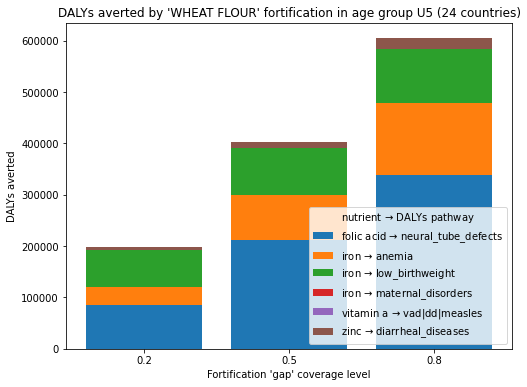

In [46]:
%%time

def lower(x):
    return x.quantile(.025)

def upper(x):
    return x.quantile(0.975)

def lsff_pathway_stacked_bar_plot(df, vehicle, age_group, legend=True, ax=None):
    if ax is None:
        ax = plt.gca()
    
    pathways = df.value_counts(['nutrient', 'cause']).sort_index().index.to_flat_index().unique()
    draw_cols = df.filter(like='draw').columns.to_list()
    year = 2025
#     coverage_levels = [0.2, 0.5, 0.8]
    x_variable = 'coverage_level' # x could be country instead, for a fixed coverage level
    measure = 'counts_averted' # y_variable -- needs to be additive for a stacked bar chart
    filters = [
#         f"coverage_level != {0.2 if 'zero' in vehicle else 1.0}", # since gap coverage 1.0 is missing from iron->BW results
        f"coverage_level != 1.0", # since gap coverage 1.0 is missing from iron->BW results
        "location_id != 11", # since location_id 11 (Indonesia) is missing from iron->anemia results
        "vehicle==@vehicle",
        "age_group==@age_group",
        "measure==@measure",
        "year==@year", # since iron only has results for 2025
    ]
#     if 'zero' in vehicle:
#         filters.append('coverage_level == -1.0')
    df = df.query(" and ".join(filters))
    # If there's no data to plot, just exit
    if df.empty:
        return ax
    location_ids = df['location_id'].unique()
    locations = "\n".join(ids_to_names('location', *location_ids))
    pathway_variables = ['nutrient', 'cause']
    grouped = df.groupby([x_variable, *pathway_variables])
    # For some reason, doing .agg(['mean', lower, upper], axis=1) dropped the
    # names of the levels in the index, so I use .T.describe().T instead
    data = grouped[draw_cols].sum().T.describe(percentiles=[.025,.975]).T#.agg(['mean', lower, upper], axis=1)
    assert len(location_id_lists := grouped['location_id'].unique().map(sorted).map(tuple).unique()) == 1, \
        f"Locations don't match between nutrient pathways: {location_id_lists}"
    
    x_values = data.index.unique(x_variable)
#     x = np.arange(len(x_values))
    # Make values evenly spaced, and put them in consistent locations for multiple axes plotted together
    x = x_values.map({-1: 0, 0.2: 1, 0.5: 2, 0.8: 3, 1.0: 4})
    bottom = np.zeros(len(x_values))
    # Each pathway is a (nutrient, cause) pair -- find unique pathways
    # by ignoring coverage level in index and finding all such pairs
    # pathways = data.index.droplevel('coverage_level').to_flat_index().unique()
    for pathway in pathways:
        try:
            mean = data.xs(pathway, level=pathway_variables)['mean']
        except KeyError as e:
            # If pathway does not exist for the given data, plot an empty bar
            # (of height 0) so that the color cycle counts all pathways,
            # thus keepint the same color for each pathway in all plots
            mean = 0
            # No need to filter x-values since scalar 0 will be broadcast across all
            x_mask = (x == x)
            # print(e)
        else:
            # Filter to coverage levels present for this pathway
            x_mask = np.isin(x_values, mean.index)

#         print(pathway, x, x_values, x[x_mask], mean)
        ax.bar(x[x_mask], mean, bottom=bottom[x_mask], label=fr'{pathway[0]} $\to$ {pathway[1]}')
        bottom[x_mask] += mean
        
    ax.set_xticks(x)
    ax.set_xticklabels(x_values.map(lambda x: 'remove baseline' if x==-1 else x))
    ax.set_xlabel("Fortification 'gap' coverage level")
    ax.set_ylabel('DALYs averted')

    if legend:
        # https://stackoverflow.com/questions/25068384/bbox-to-anchor-and-loc-in-matplotlib
#         ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title=r'nutrient $\to$ DALYs pathway')
        ax.legend(title=r'nutrient $\to$ DALYs pathway')
    location_string = (
        f" ({len(location_ids)} countries)" if len(location_ids) > 1 else
        f" ({ids_to_names('location', *location_ids).iloc[0]})"
    )
    ax.set_title(
        f"DALYs averted by '{vehicle.upper()}' fortification in age group {age_group.upper()}"
        + location_string
#         f"\nin {len(location_ids)} location{'s' if len(location_ids) > 1 else ' (' + ids_to_names('location', *location_ids).iloc[0] + ')'}"
    )
    return data, ax
    

    
fig, ax = plt.subplots(figsize=(8,6))
t = lsff_pathway_stacked_bar_plot(filled_results, 'wheat flour', 'u5', ax=ax)

In [47]:
t[0].xs('folic acid', level='nutrient')

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,,count,mean,std,min,2.5%,50%,97.5%,max
coverage_level,cause,,,,,,,,
0.2,neural_tube_defects,1000.0,84705.001472,22333.941636,38563.066965,51711.993111,81144.593625,139448.916398,194187.836943
0.5,neural_tube_defects,1000.0,211762.503681,55834.854090,96407.667413,129279.982777,202861.484062,348622.290995,485469.592356
0.8,neural_tube_defects,1000.0,338820.005890,89335.766544,154252.267861,206847.972443,324578.374500,557795.665592,776751.347770


In [48]:
t[0].index.unique('coverage_level')#.map({-1: 0, 0.2: 1, 0.5: 2, 0.8: 3, 1.0: 4})

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Float64Index([0.2, 0.5, 0.8], dtype='float64', name='coverage_level')

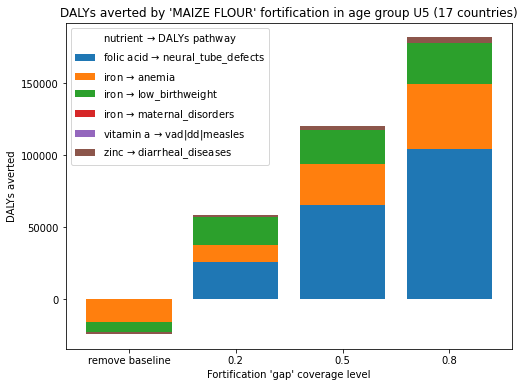

In [49]:
fig, ax = plt.subplots(figsize=(8,6))
t = lsff_pathway_stacked_bar_plot(results_zero_100, 'maize flour', 'u5', ax=ax)

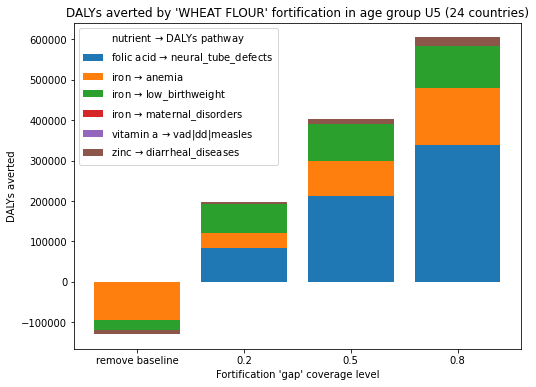

In [50]:
fig, ax = plt.subplots(figsize=(8,6))
t = lsff_pathway_stacked_bar_plot(results_zero_100, 'wheat flour', 'u5', ax=ax)

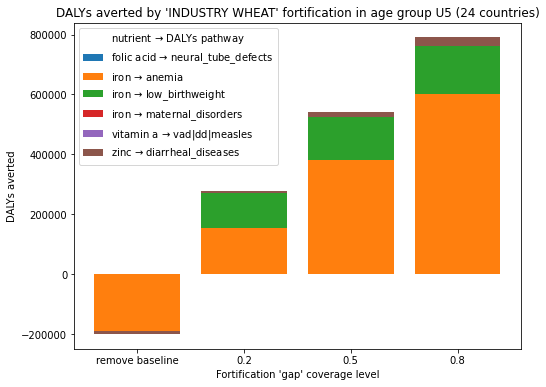

In [51]:
fig, ax = plt.subplots(figsize=(8,6))
t = lsff_pathway_stacked_bar_plot(results_zero_100, 'industry wheat', 'u5', ax=ax)

In [52]:
filled_results.nutrient.unique()

array(['iron', 'folic acid', 'zinc', 'vitamin a'], dtype=object)

In [53]:
ids_to_names('location', *results.location_id.unique())

location_id
6                                 China
11                            Indonesia
15                              Myanmar
20                             Viet Nam
141                               Egypt
161                          Bangladesh
163                               India
164                               Nepal
165                            Pakistan
168                              Angola
171    Democratic Republic of the Congo
179                            Ethiopia
180                               Kenya
181                          Madagascar
184                          Mozambique
189         United Republic of Tanzania
190                              Uganda
196                        South Africa
201                        Burkina Faso
202                            Cameroon
205                       Côte d'Ivoire
207                               Ghana
213                               Niger
214                             Nigeria
522                         

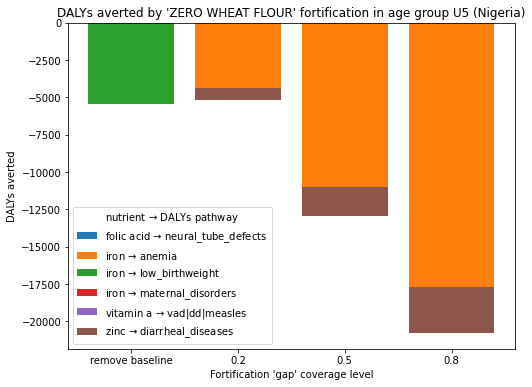

In [54]:
fig, ax = plt.subplots(figsize=(8,6))
lsff_pathway_stacked_bar_plot(filled_results.query("location_id==214"), 'zero wheat flour', 'u5');

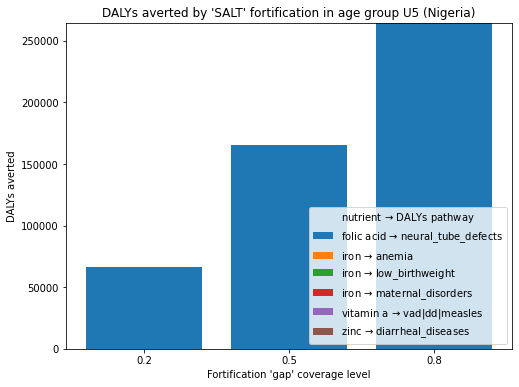

In [55]:
fig, ax = plt.subplots(figsize=(8,6))
lsff_pathway_stacked_bar_plot(filled_results.query("location_id==214"), 'salt', 'u5');

In [56]:
results.vehicle.unique()

array(['wheat flour', 'maize flour', 'zero wheat flour',
       'zero maize flour', 'industry wheat', 'zero industry wheat',
       'salt', 'industry oil', 'oil', 'zero industry oil', 'zero oil'],
      dtype=object)

# Plot all vehicles and age groups together...

In [57]:
v = 'wheat flour'
v = 'oil'
# v = 'maize flour'
f"industry {v[:-6] if v.endswith(' flour') else v}"

'industry oil'

CPU times: user 1.14 s, sys: 46 ms, total: 1.19 s
Wall time: 1.19 s


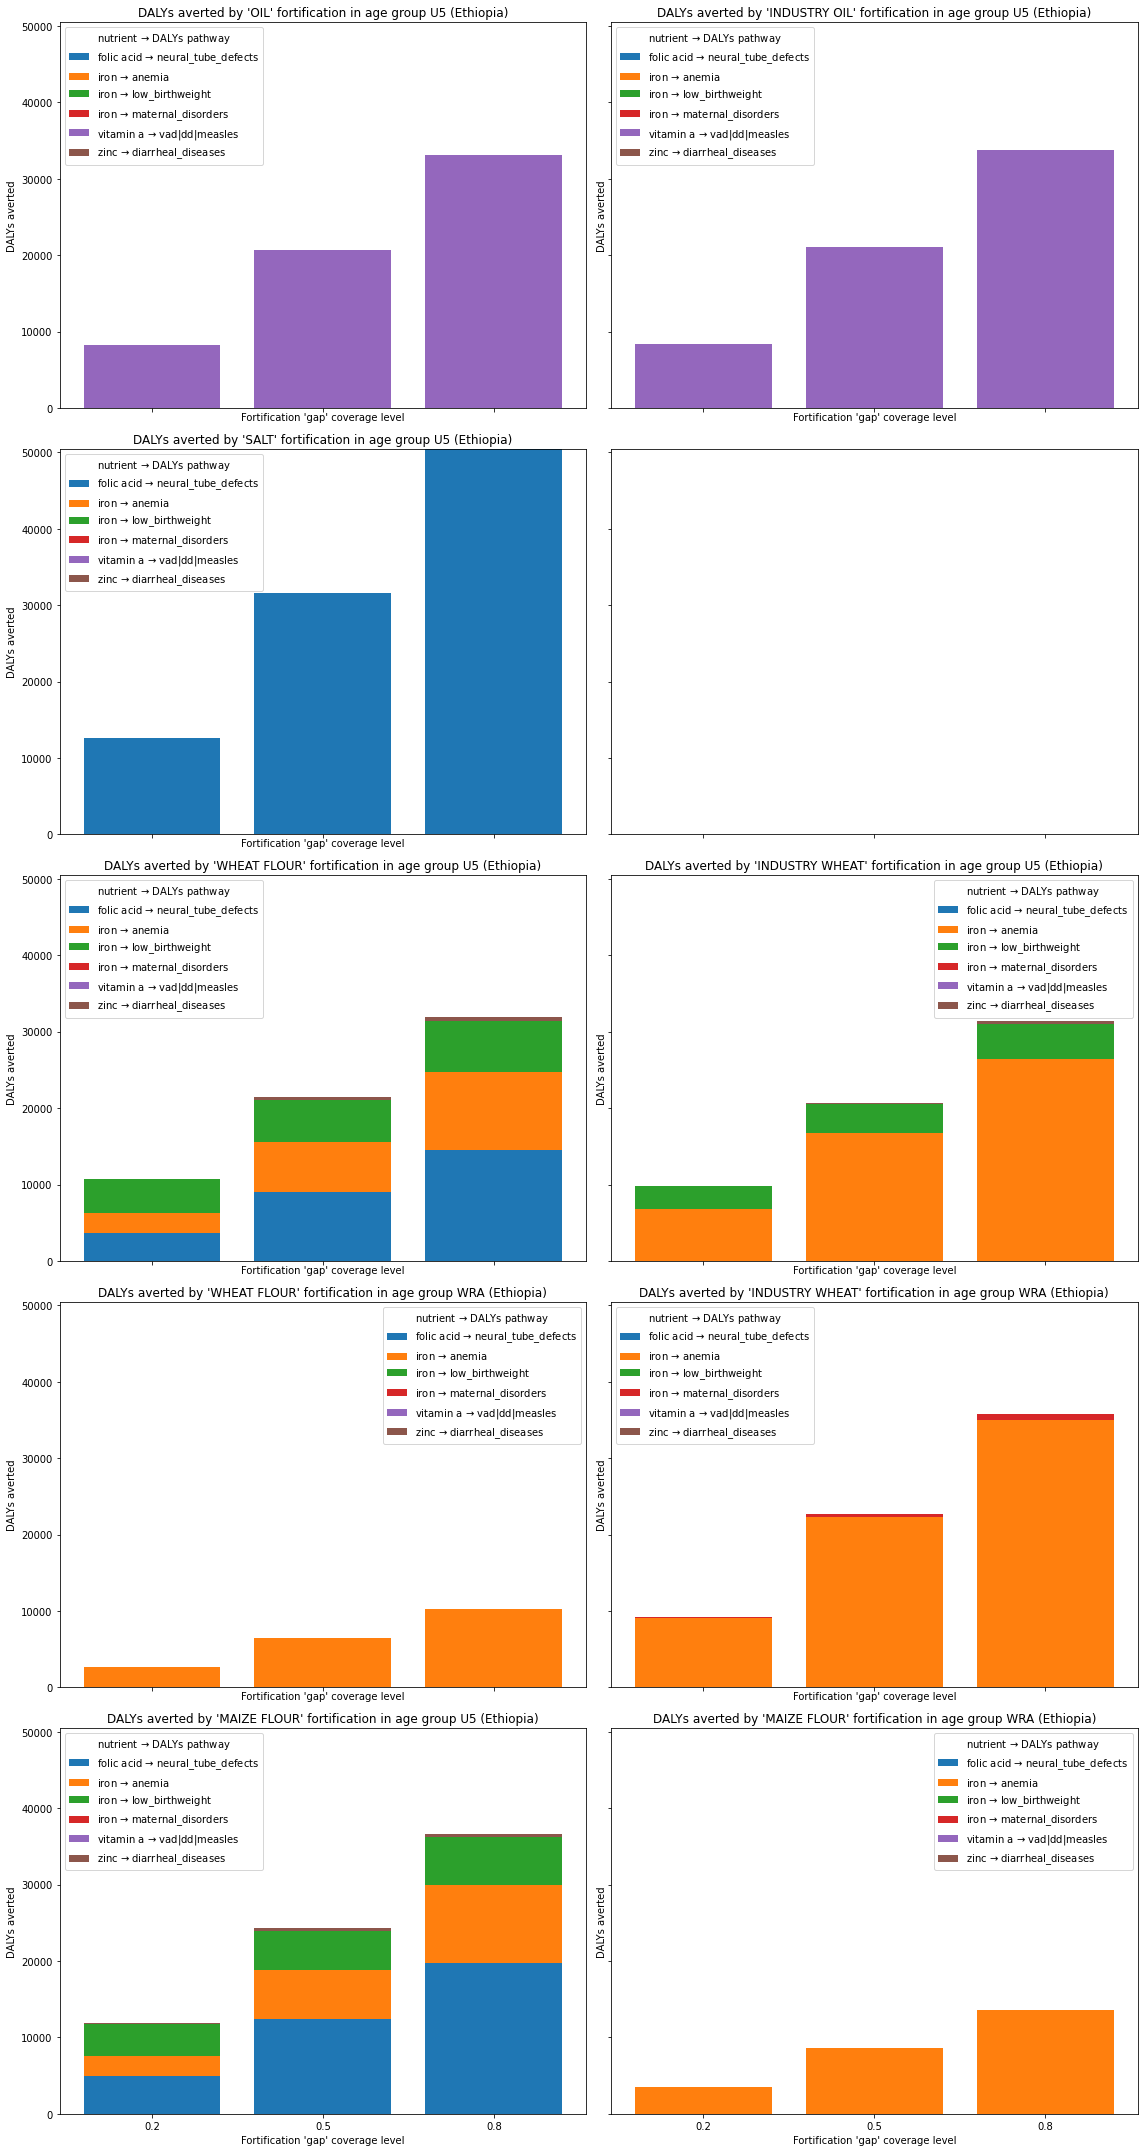

In [58]:
%%time
def plot_all_vehicles_and_age_groups(df):
    rows = (
        ('oil', 'u5'),
        ('salt', 'u5'), # Note: industry salt doesn't exist
        ('wheat flour', 'u5'),
        ('wheat flour', 'wra'),
        ('maize flour', 'u5'), # This row breaks pattern because there's no 'industry maize'
    )
    n_rows = len(rows)
    n_cols = 2 # 1st column for regular, 2nd column for 'industry' version
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows), sharex=True, sharey=True)
    for row_num, (vehicle, age_group) in enumerate(rows):
        if vehicle in ['maize flour']:
            vehicle2 = vehicle
            age_group2 = 'wra'
        else:
            vehicle2 = f"industry {vehicle[:-6] if vehicle.endswith(' flour') else vehicle}"
            age_group2 = age_group

        lsff_pathway_stacked_bar_plot(df, vehicle, age_group, legend=True, ax=axs[row_num, 0])
        lsff_pathway_stacked_bar_plot(df, vehicle2, age_group2, legend=True, ax=axs[row_num, 1])
#     fig.suptitle(r"DALYs averted by nutrient $\to$ cause pathway for each vehicle")
    fig.tight_layout()
    return fig

fig = plot_all_vehicles_and_age_groups(filled_results.query("location_id==179"))

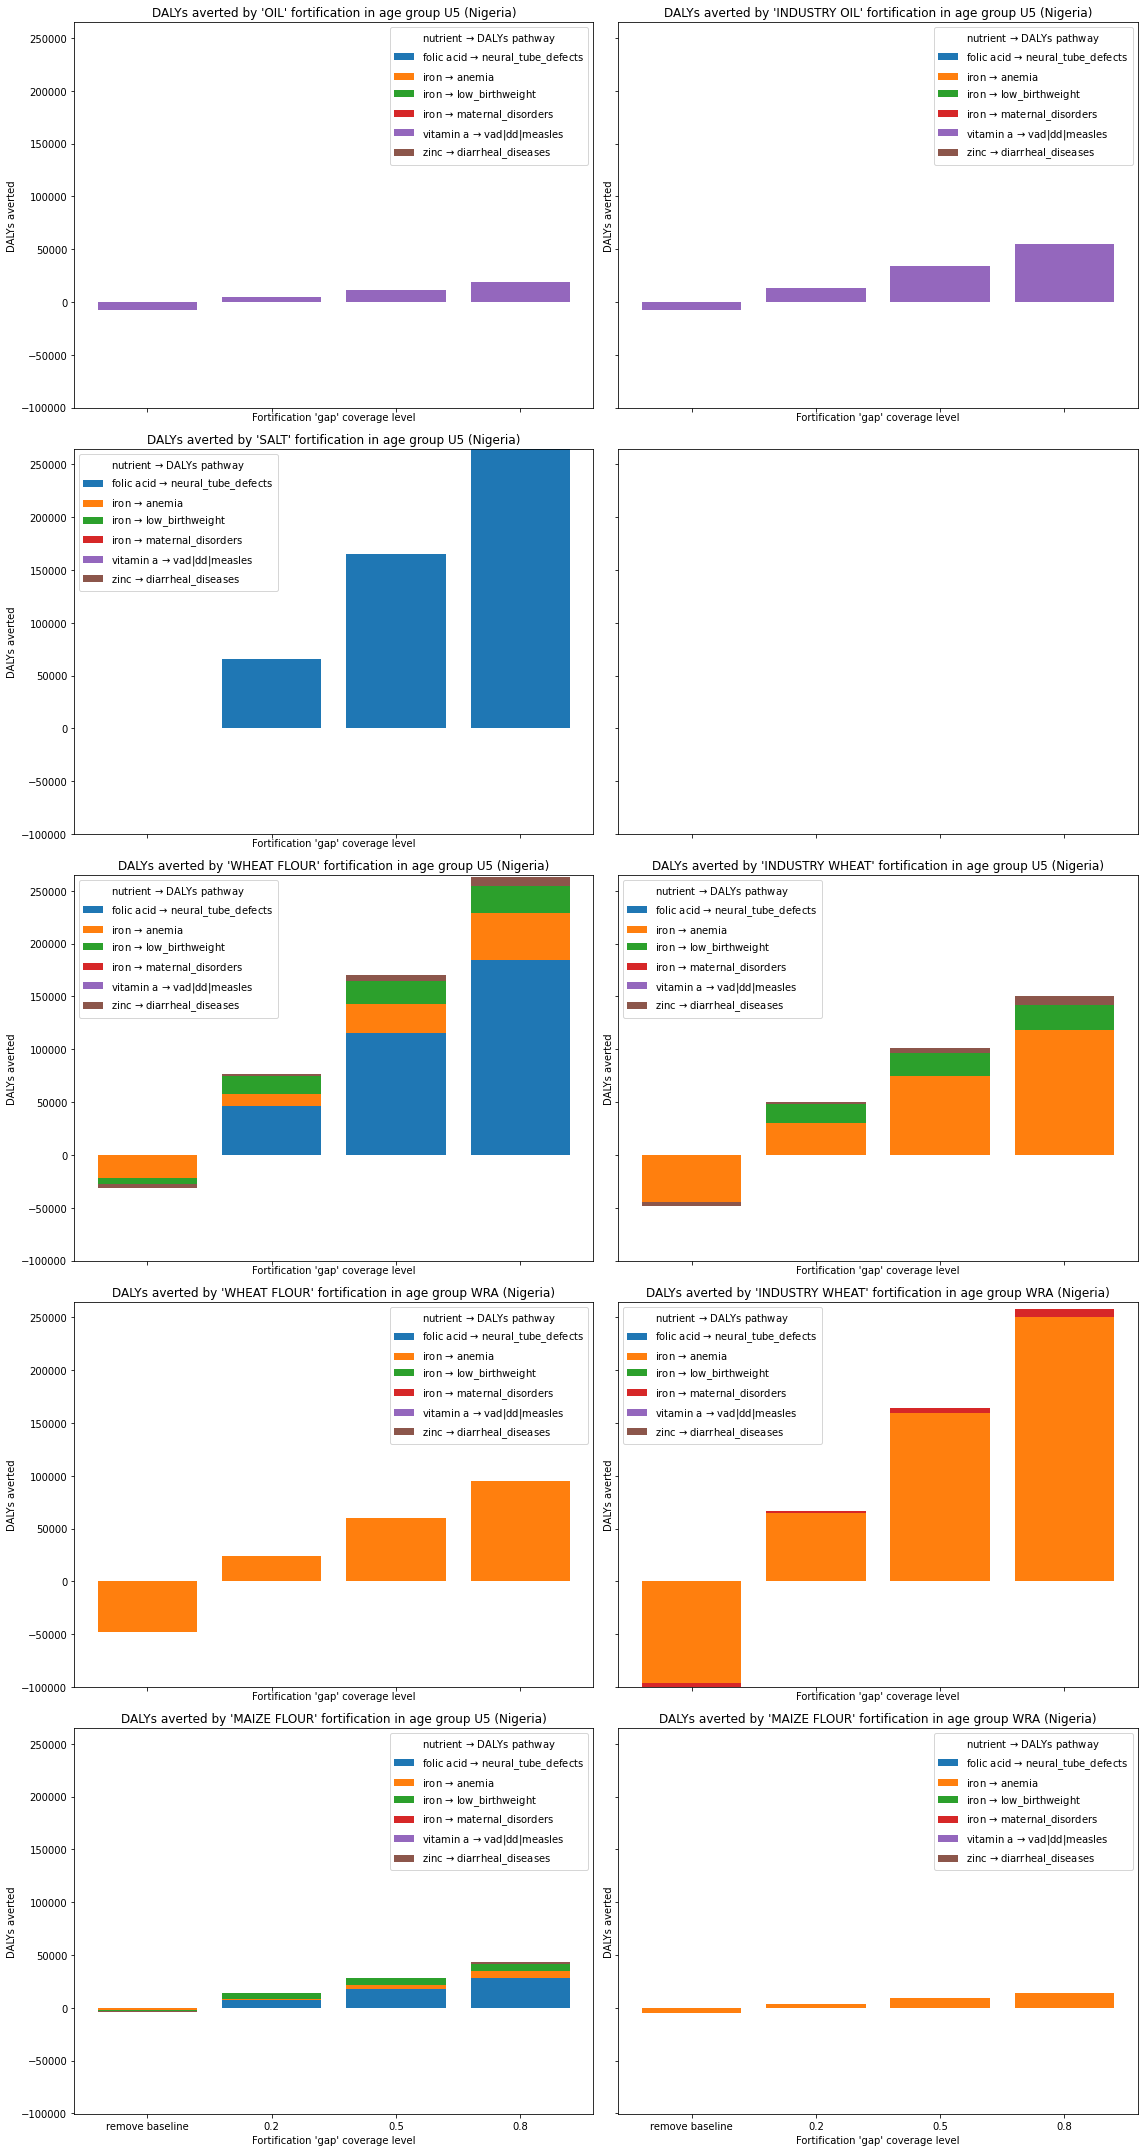

In [59]:
fig = plot_all_vehicles_and_age_groups(results_zero_100.query("location_id==214"))

In [60]:
results.query("location_id==11 and cause == 'anemia'").vehicle.unique()

array(['industry wheat', 'zero industry wheat', 'zero wheat flour'],
      dtype=object)

# Test plotting functions copied to module

In [61]:
import results_pathway_plots as rpp

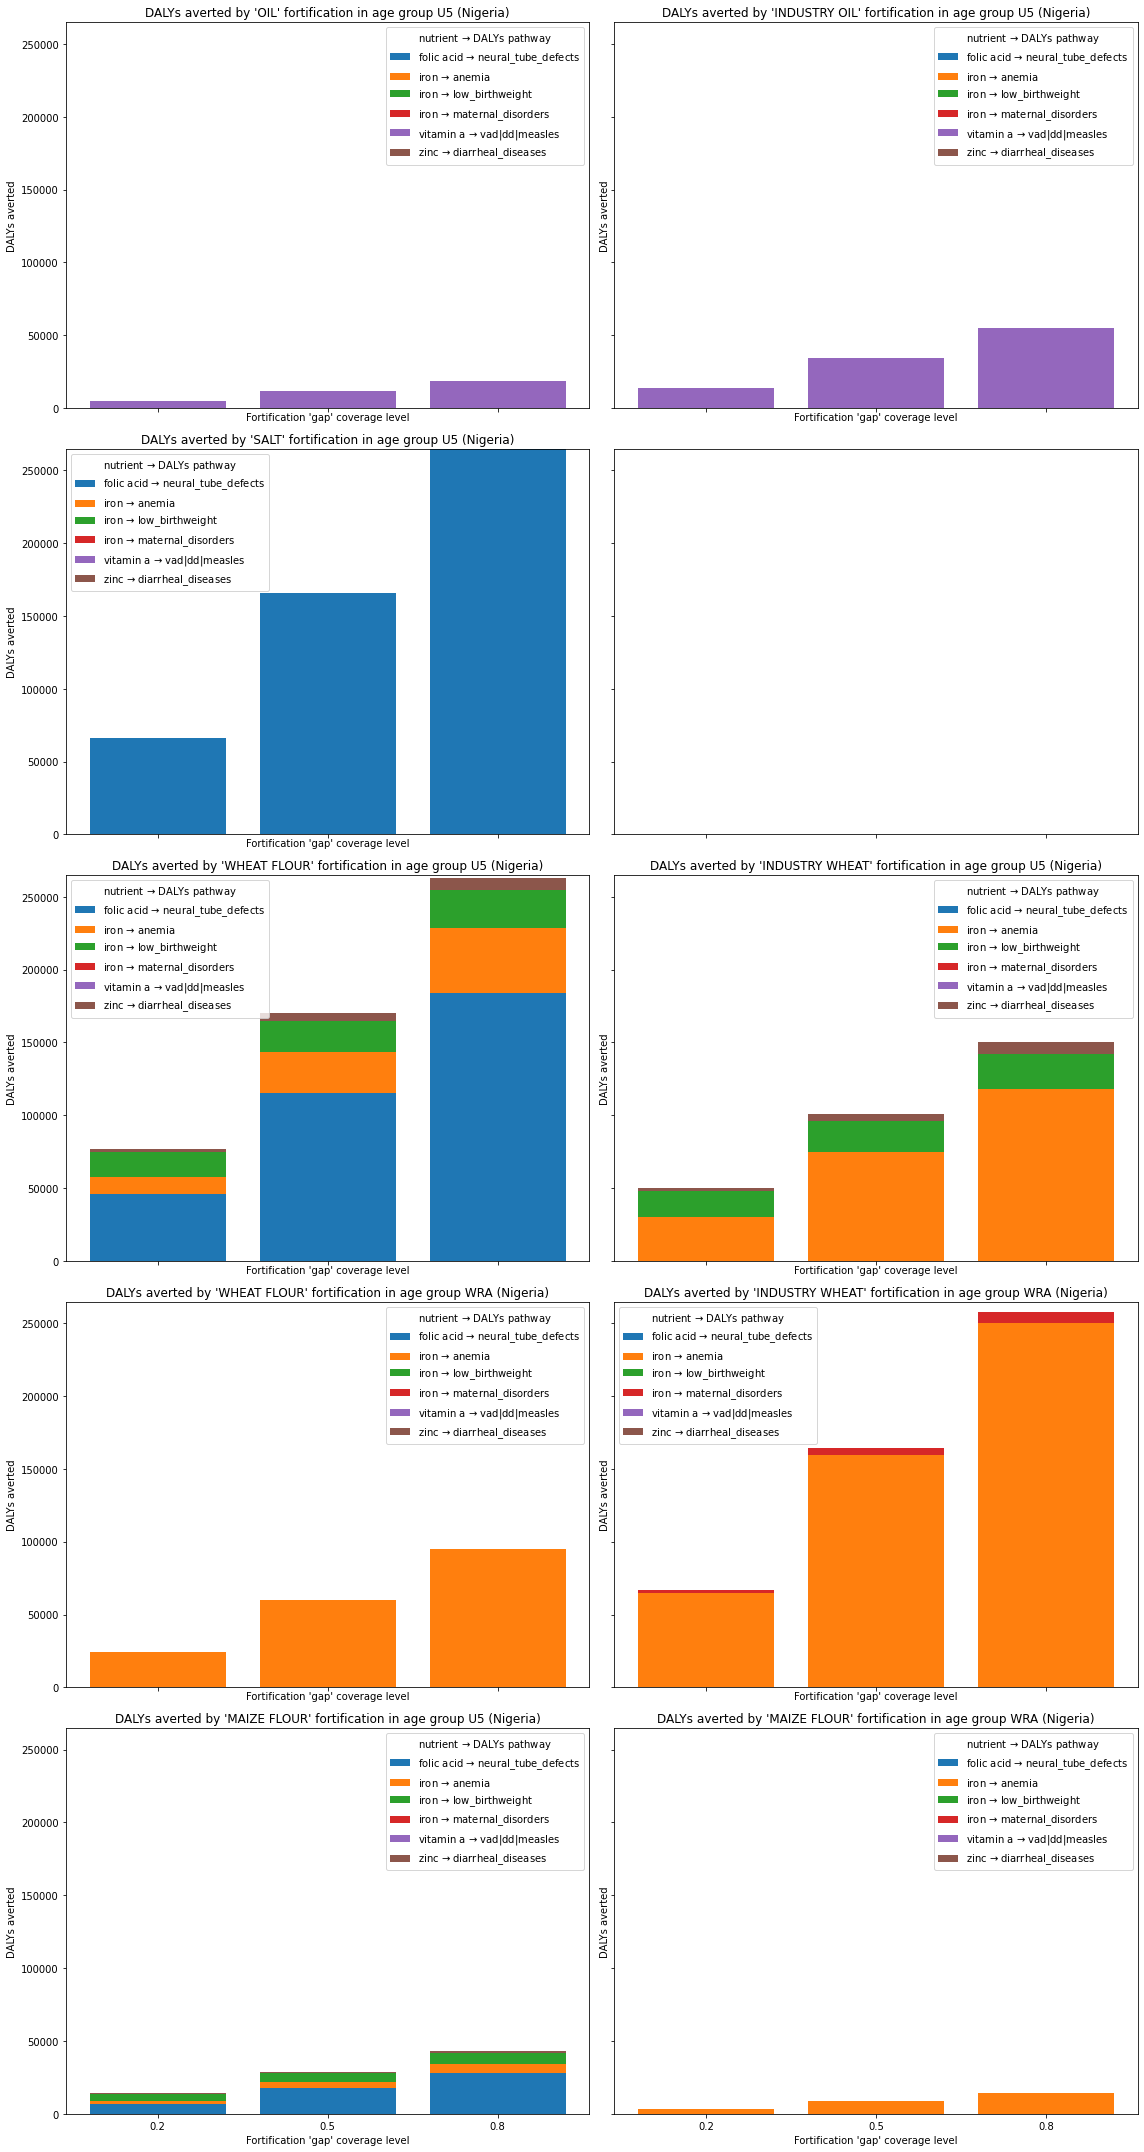

In [62]:
fig = rpp.plot_all_vehicles_and_age_groups(filled_results.query("location_id==214"))

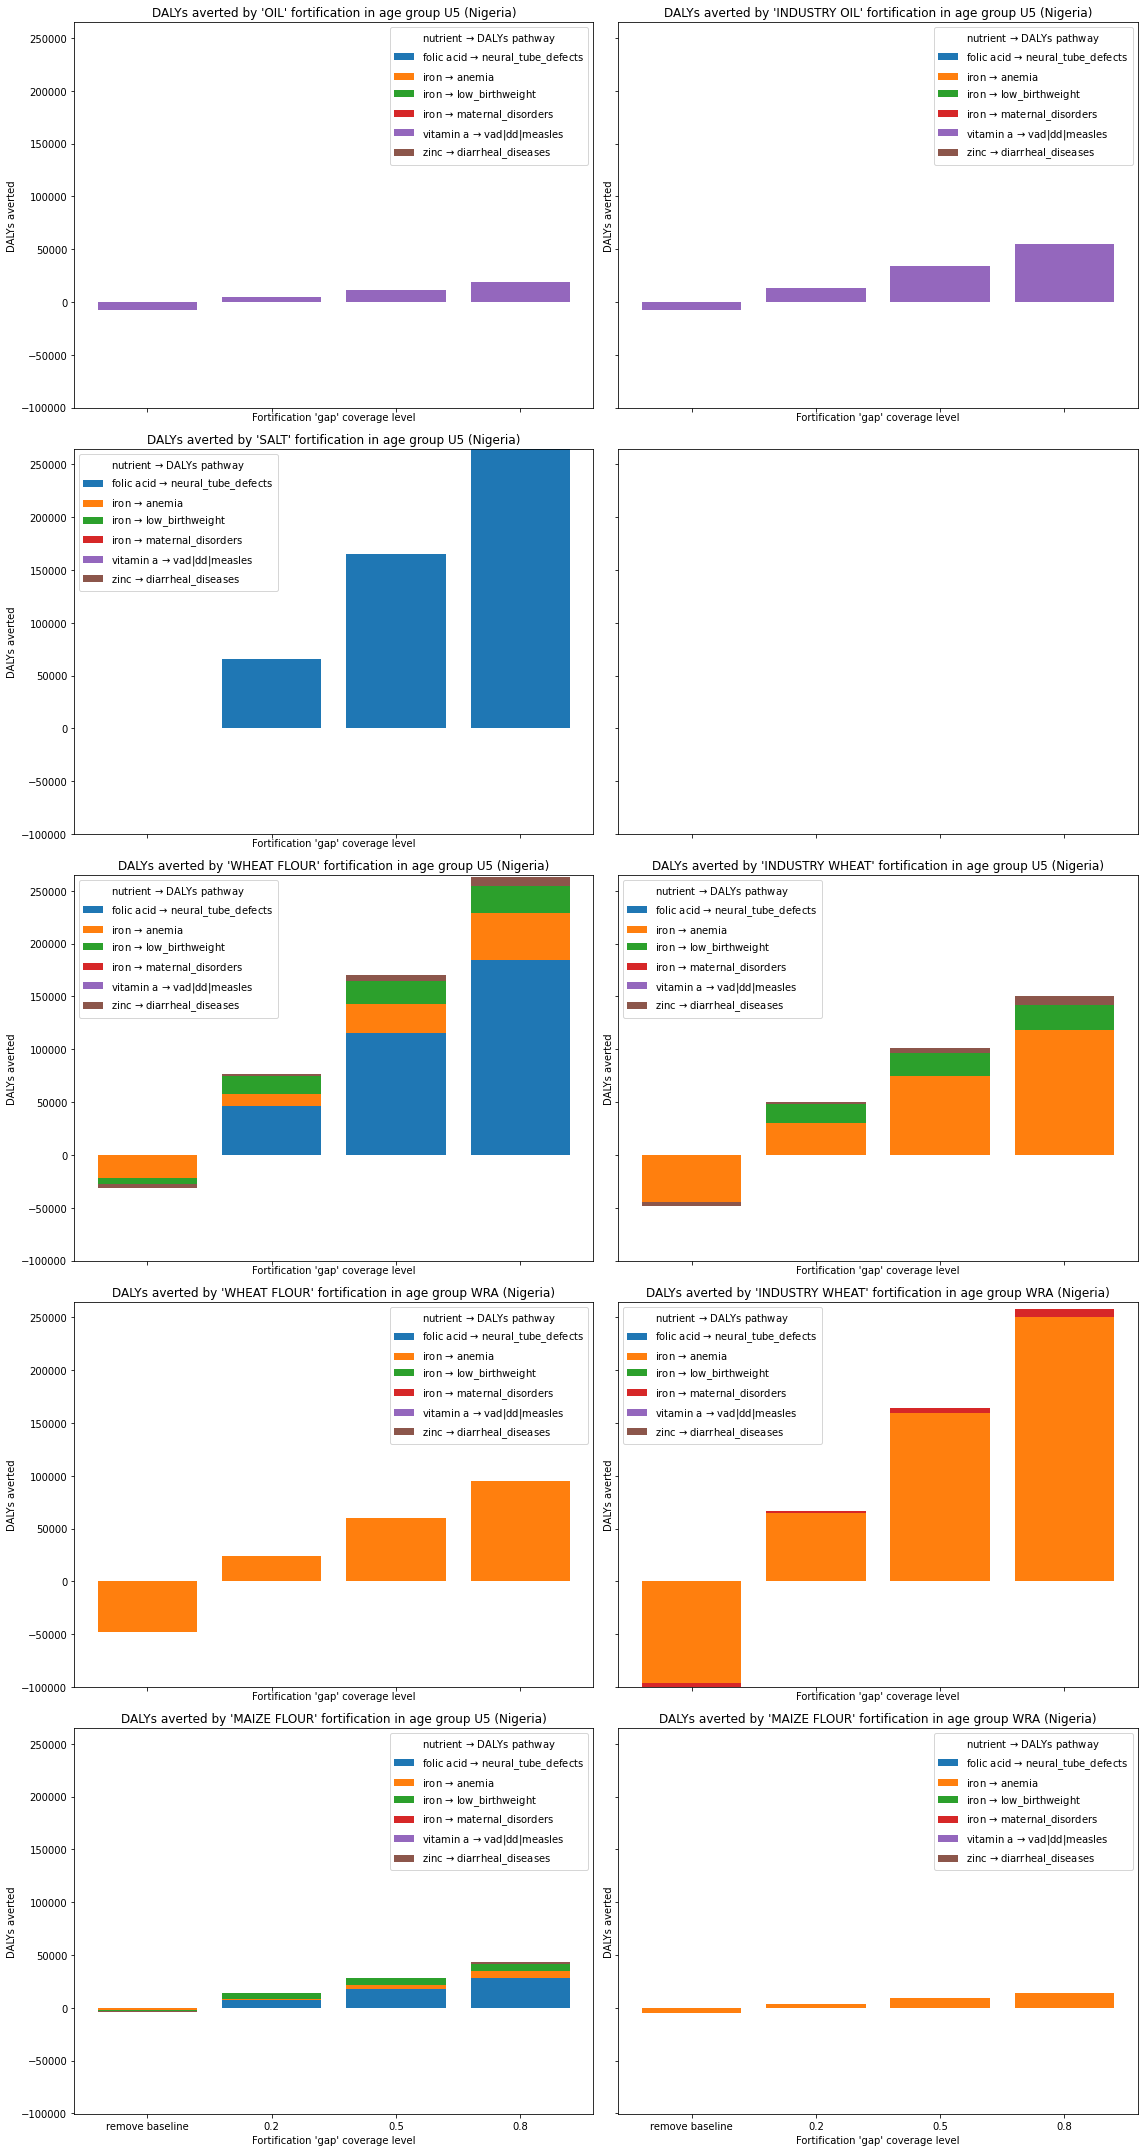

In [63]:
fig = rpp.plot_all_vehicles_and_age_groups(results_zero_100.query("location_id==214"))

# Generate final figures for Nigeria, India, Ethiopia, and all countries combined

In [64]:
search_id_table('location', "Nigeria|Ethiopia|^India$")

,location_id,location_name,location_type,location_description
137,163,India,admin0,admin0
150,179,Ethiopia,admin0,admin0
183,214,Nigeria,admin0,admin0
213,330,Ethiopia PDR,admin0,admin0
288,53485,Ethiopia Special Enumeration Areas,admin0,Added per INF-4646
312,94367,Ethiopia (Sahel),admin0,Created for gbd round 7
313,94368,Nigeria (Sahel),admin0,Created for gbd round 7


In [65]:
names_to_ids('location', 'Nigeria', 'Ethiopia', 'India')

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


location_name
India       163
Ethiopia    179
Nigeria     214
Name: location_id, dtype: int64

CPU times: user 4.6 s, sys: 707 ms, total: 5.31 s
Wall time: 5.31 s


dict_keys(['dalys_averted_by_pathway_and_vehicle_all_locations', 'dalys_averted_by_pathway_and_vehicle_india_163', 'dalys_averted_by_pathway_and_vehicle_ethiopia_179', 'dalys_averted_by_pathway_and_vehicle_nigeria_214'])

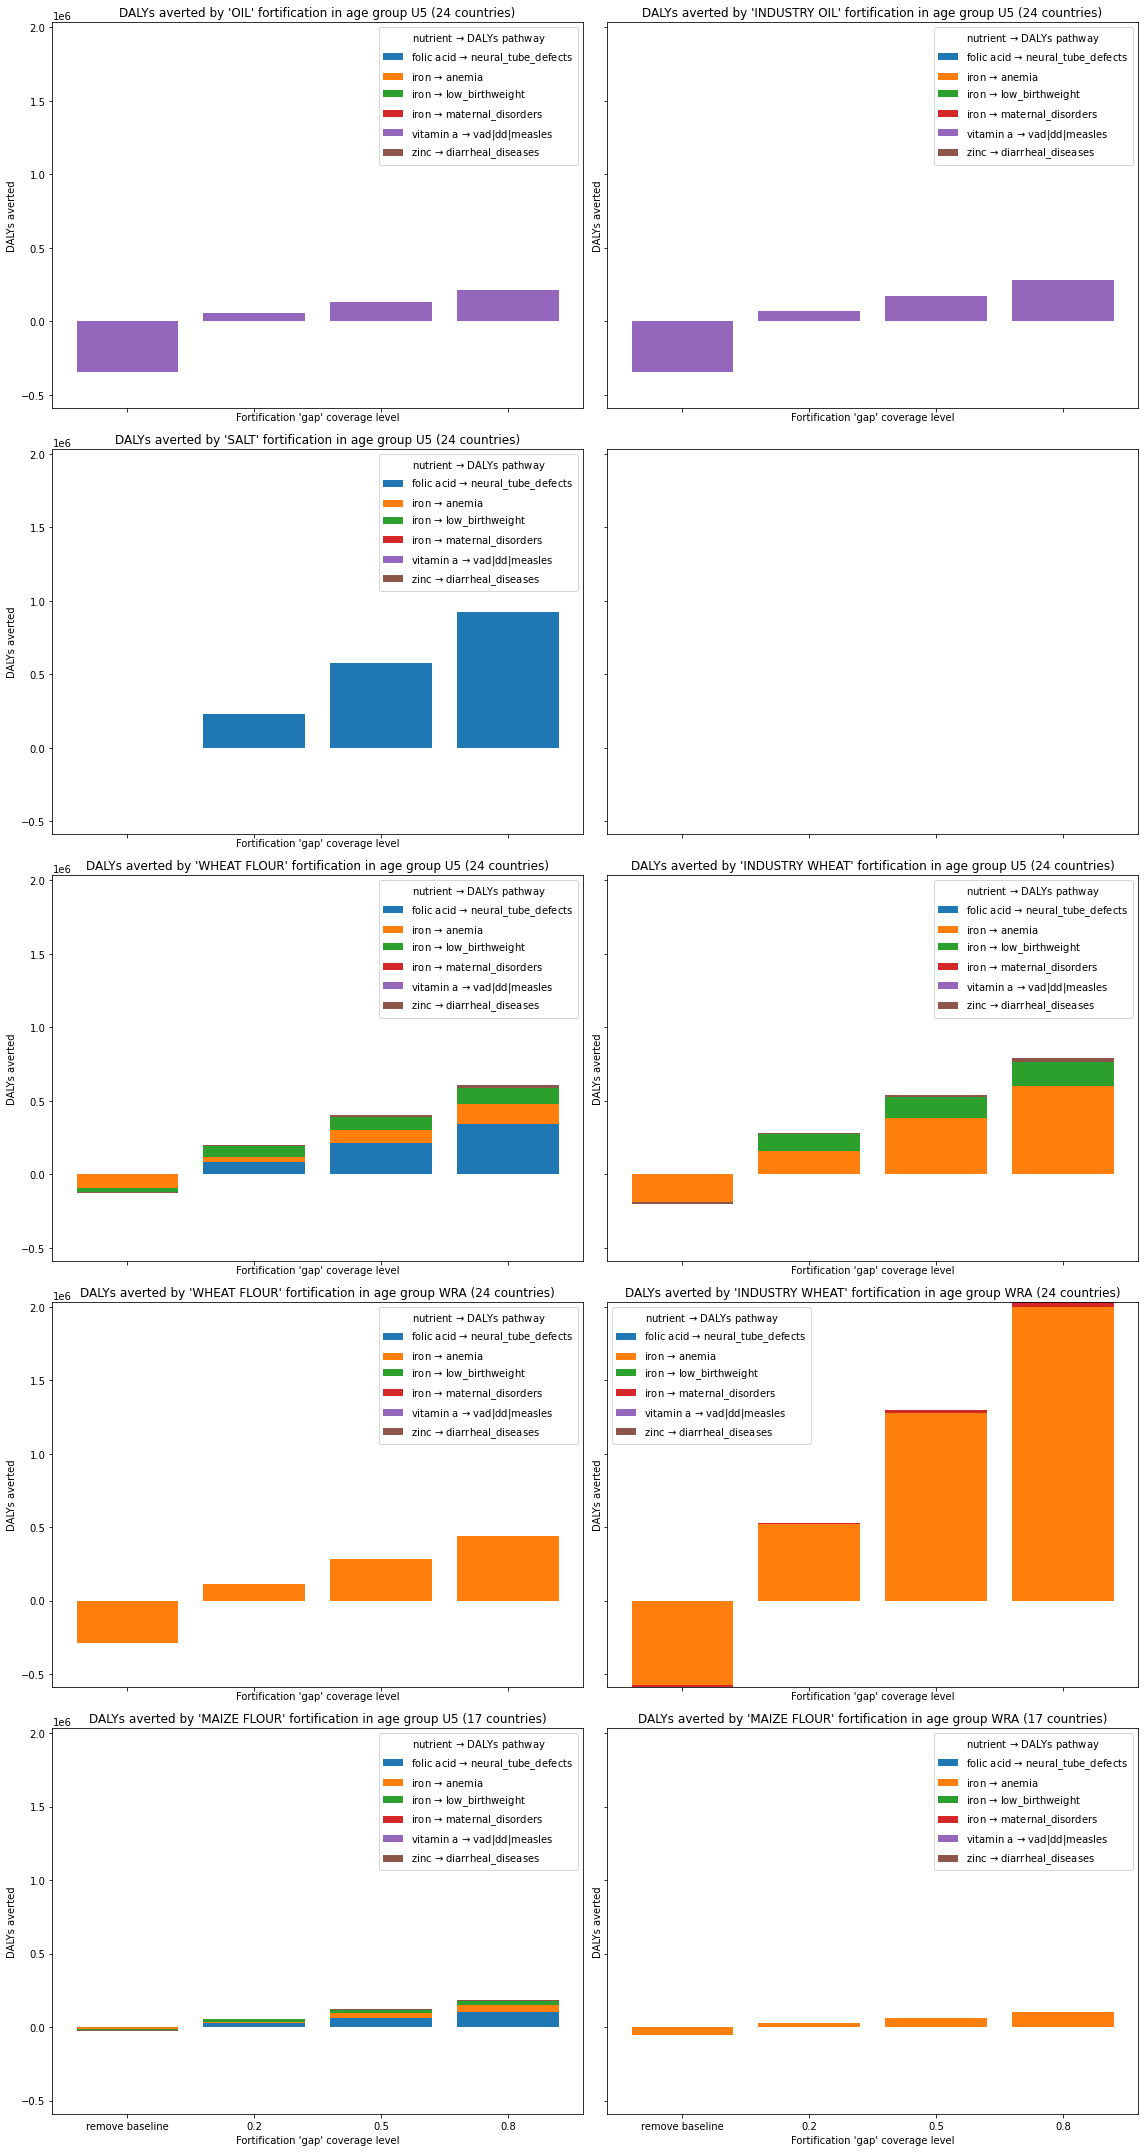

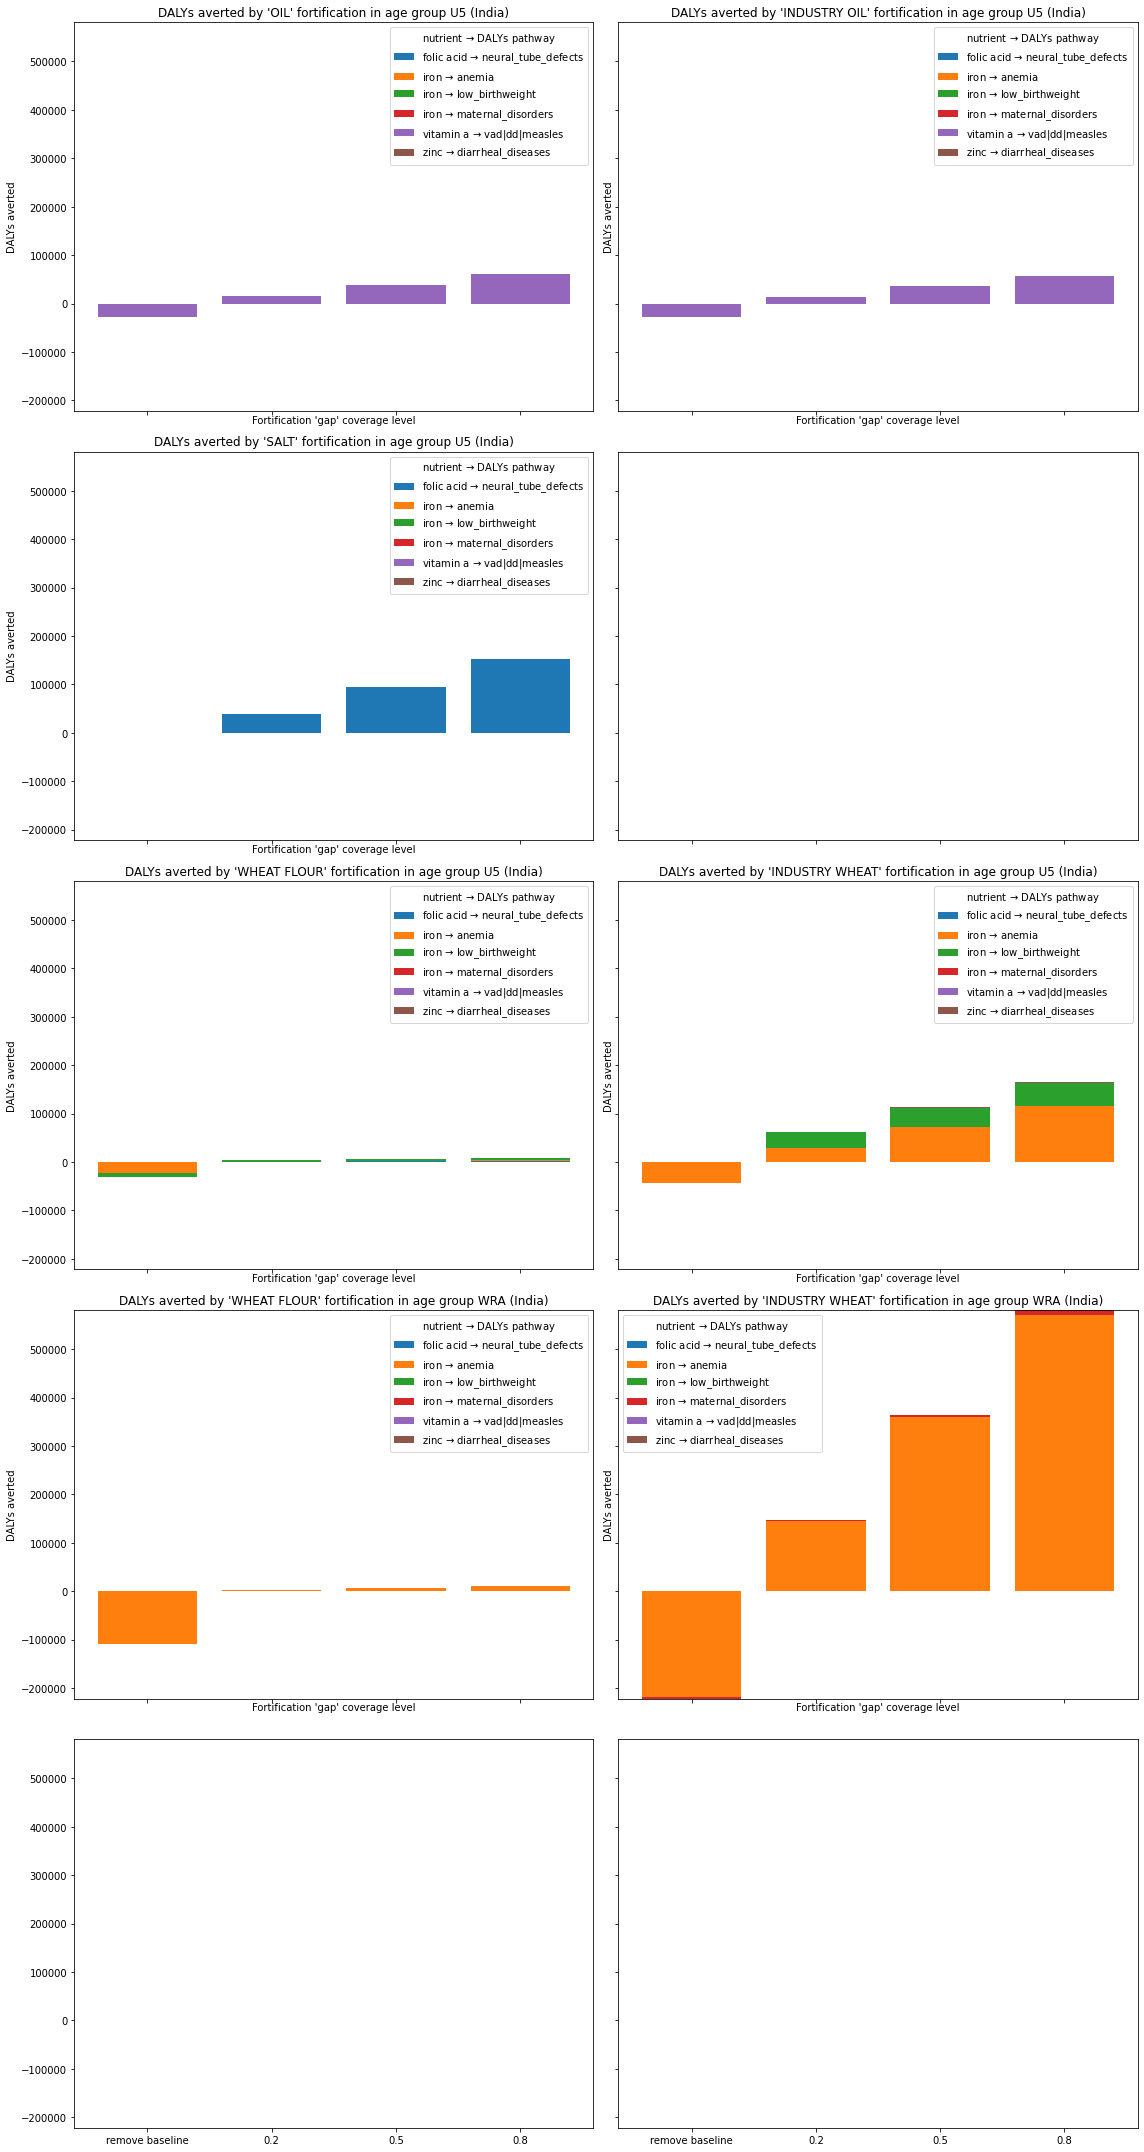

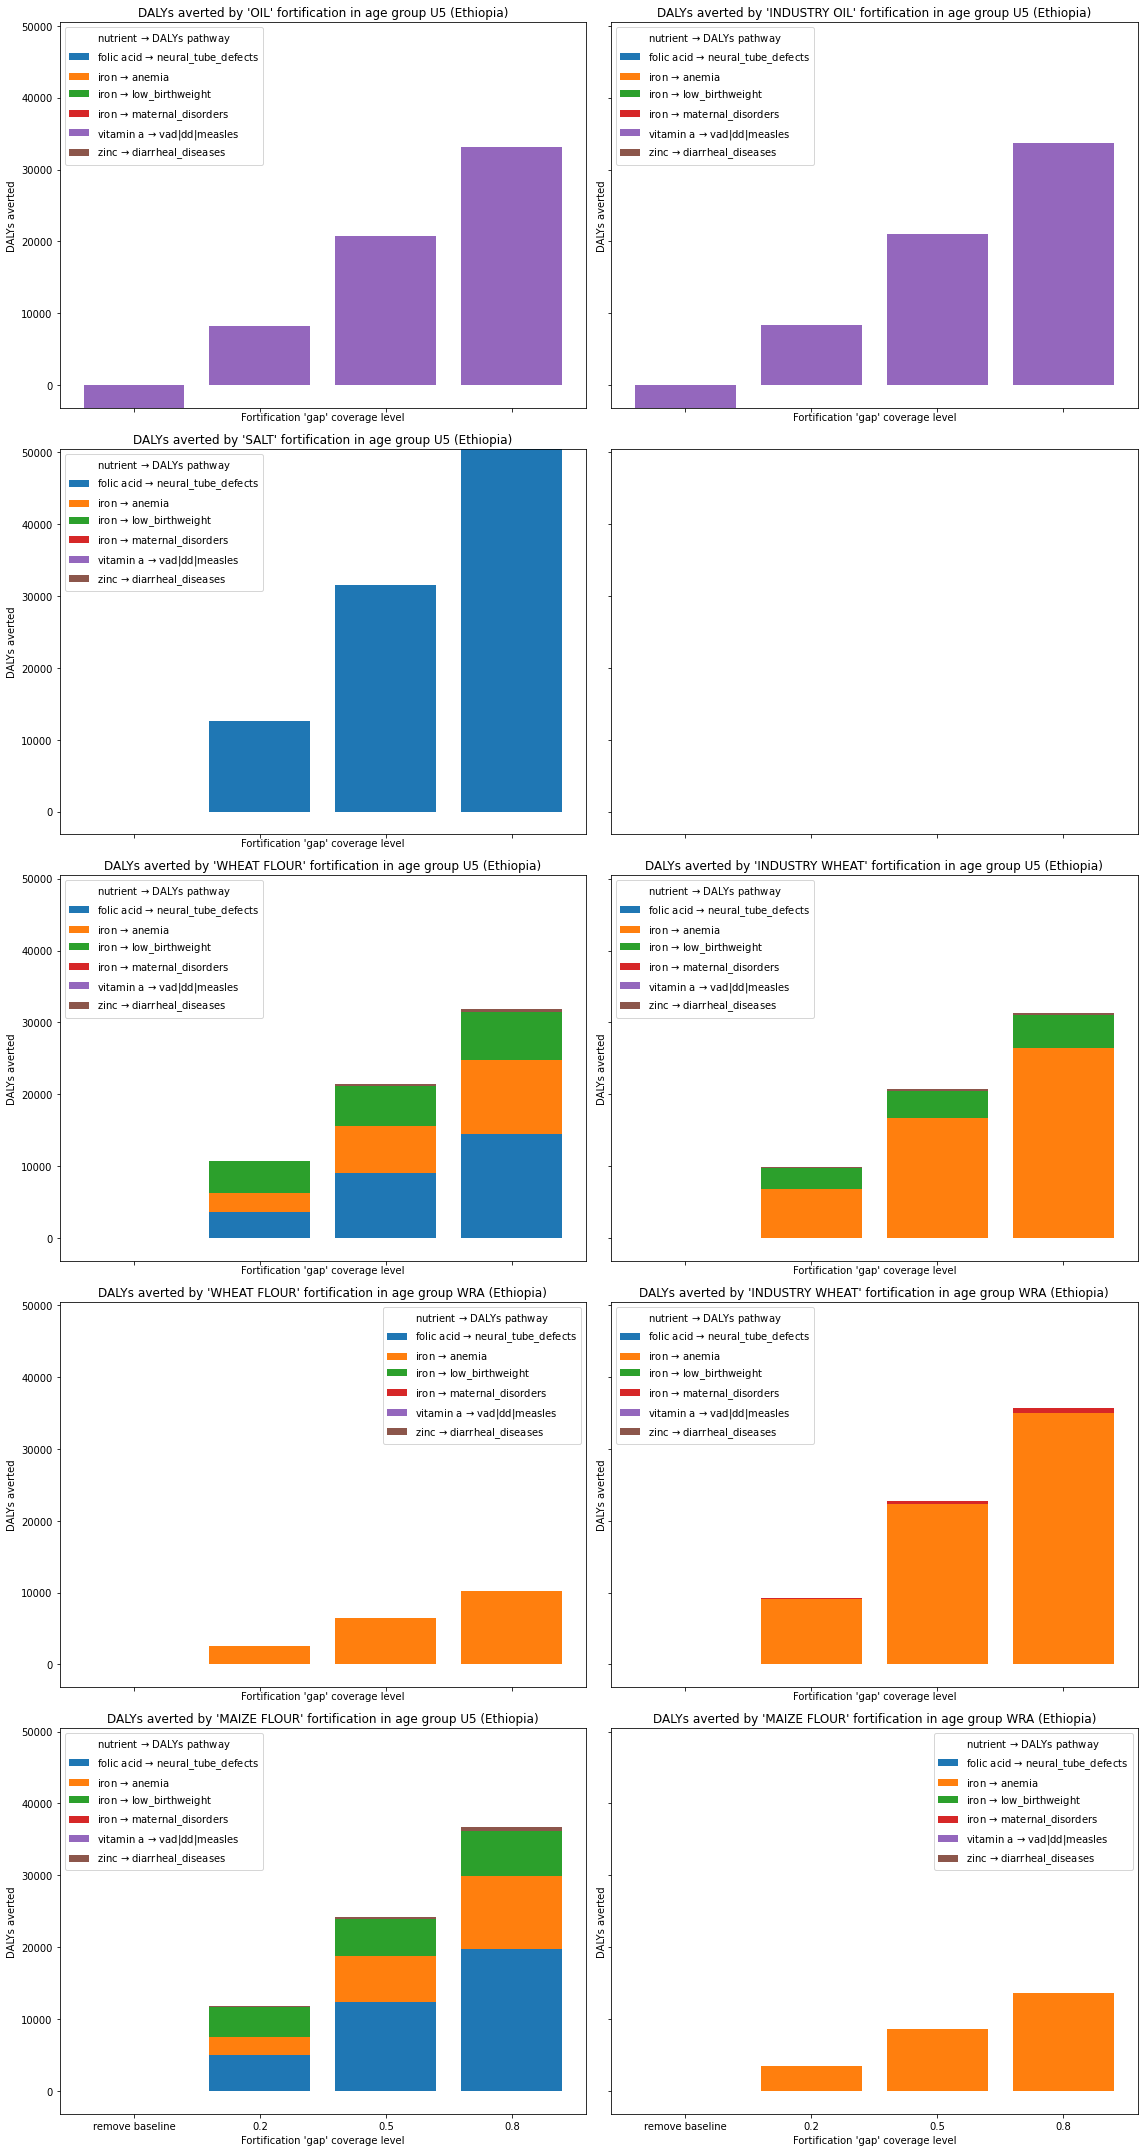

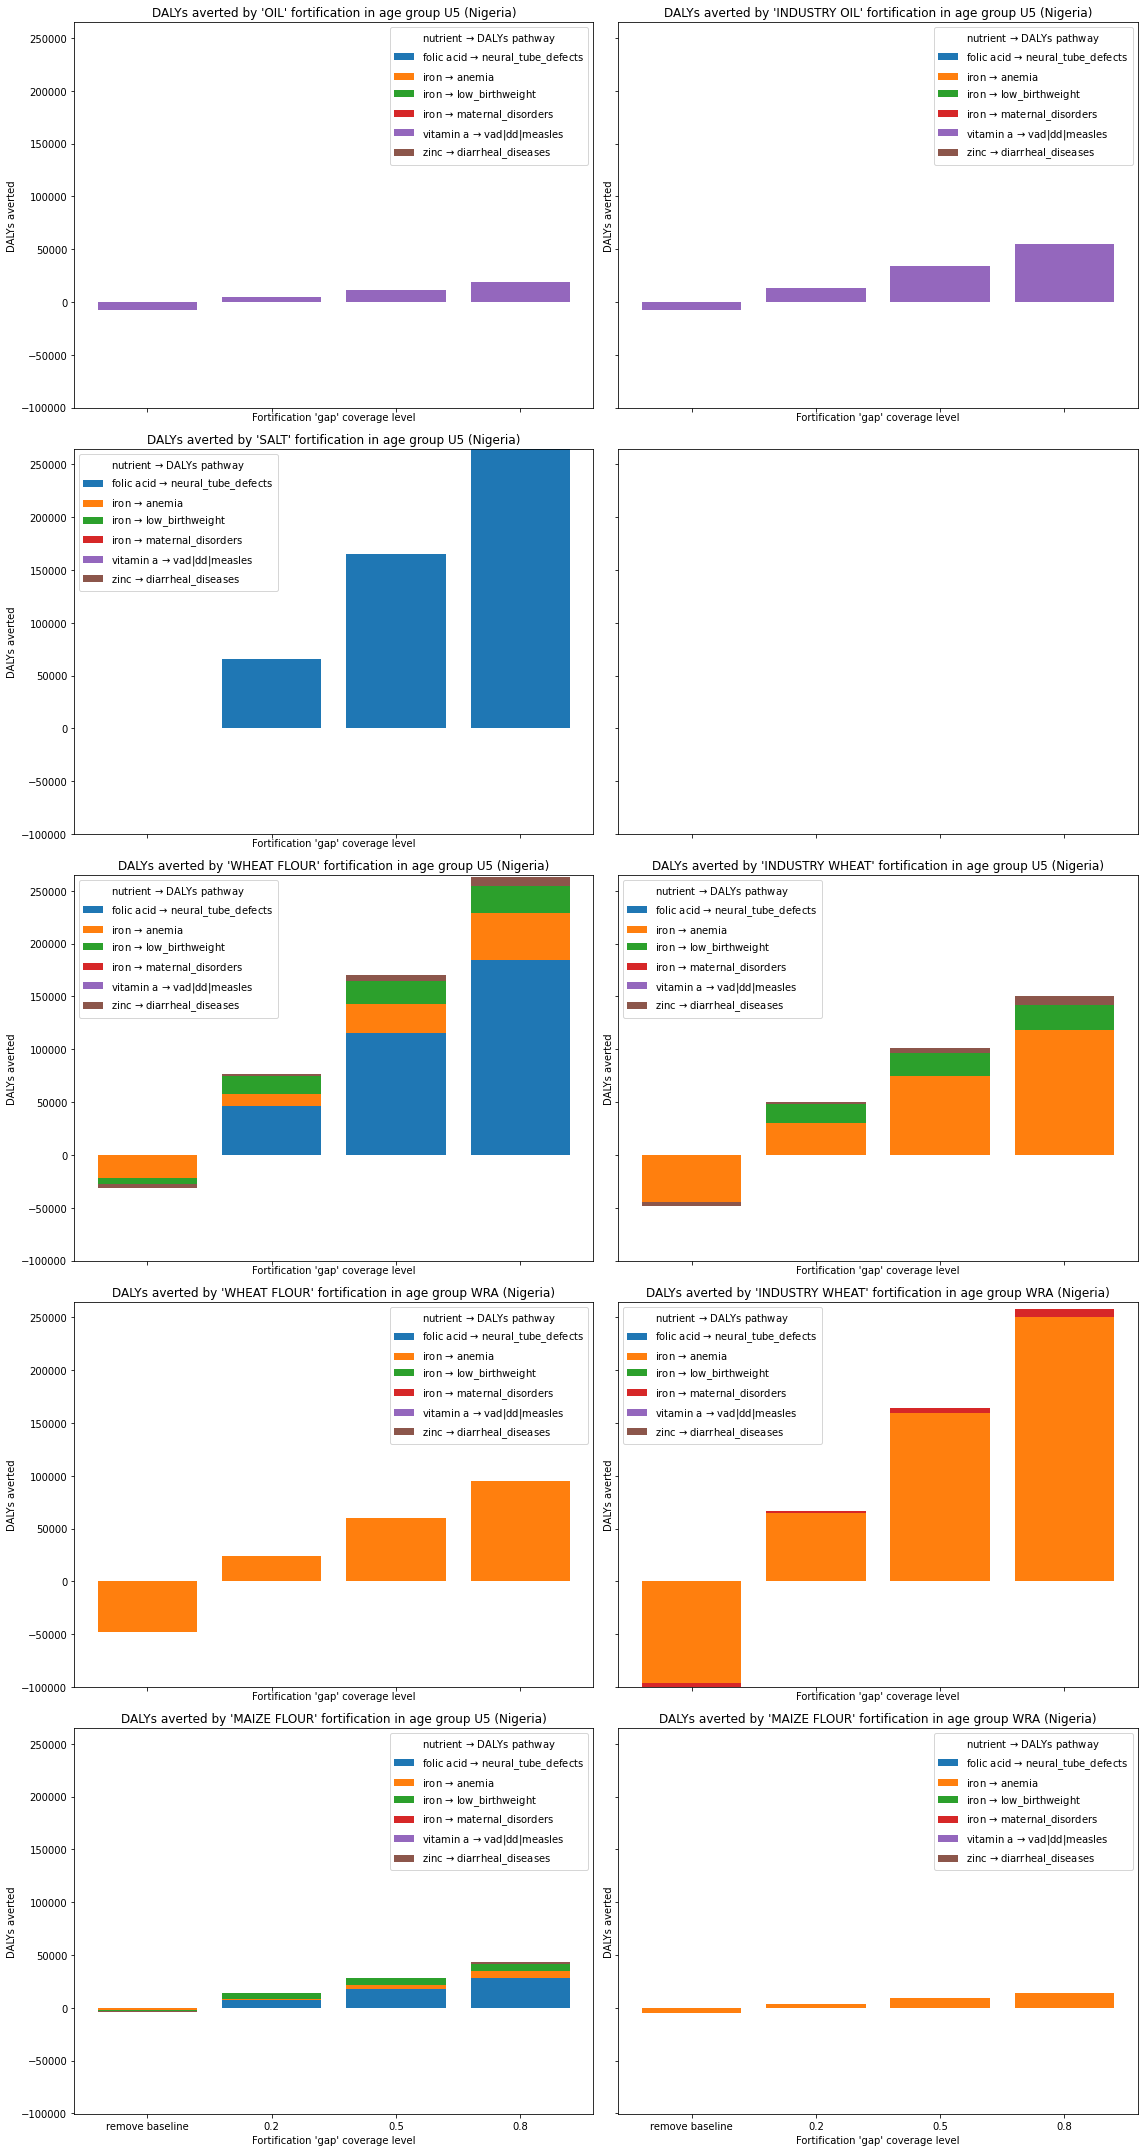

In [66]:
%%time
figs = {}
plot_type = 'dalys_averted_by_pathway_and_vehicle'
figs[f"{plot_type}_all_locations"] = rpp.plot_all_vehicles_and_age_groups(results_zero_100)

country_to_id_map = names_to_ids('location', 'Nigeria', 'Ethiopia', 'India')
for loc, loc_id in country_to_id_map.items():
    fig_title = f"{plot_type}_{loc.lower()}_{loc_id}"
    figs[fig_title] = rpp.plot_all_vehicles_and_age_groups(results_zero_100.query("location_id==@loc_id"))

figs.keys()

# Save figures

In [67]:
results_plots_path = vivarium_research_lsff_path / 'multiplication_models' / 'results_plots'
!ls $results_plots_path

costs_per_daly_by_nutrient_vehicle_pair.pdf
coverage_by_location.pdf
coverage_plots_u5.pdf
coverage_plots_wra.pdf
dalys_averted_summary_table.csv
ethiopia_counts_averted_by_nutrient_with_folic_acid_in_salt.png
ethiopia_pif_by_nutrient_with_folic_acid_in_salt.png
ethiopia_rates_averted_by_nutrient_with_folic_acid_in_salt.png
final_data_all_nutrients.csv
final_data_folic_acid.csv
final_data_iron.csv
final_data_vitamin_a.csv
final_data_zinc.csv
folic_acid_in_salt_pif.png
folic_acid_in_salt_rates_averted.png
impact_by_location.pdf
impact_by_nutrient_vehicle_pair.pdf
lower_wealth_quintile_tables
lsff_results_table_4_19_21_indonesia_industry_wheat.xlsx
lsff_results_table_4_19_21_kenya_oil_and_industry_wheat_update.xlsx
lsff_results_table_salt_4_19_21_nigeria_ethiopia_india_update.xlsx
nigeria_lower_wealth_quintile_4_14_21.xlsx
nigeria_lower_wealth_quintile_coverage_by_nutrient_vehicle_pair.pdf
nigeria_lower_wealth_quintile_impact_by_nutrient_vehicle_pair.pdf
nigeria_lower_wealth_quintile_no_

In [68]:
fig_title = 'dalys_by_pathway_and_vehicle_india_163'
(results_plots_path / fig_title).with_suffix('.png')

PosixPath('/mnt/share/homes/ndbs/vivarium_research_lsff/multiplication_models/results_plots/dalys_by_pathway_and_vehicle_india_163.png')

In [69]:
%%time
for fig_title, fig in figs.items():
    fig_filename = results_plots_path / fig_title
    fig.savefig(fig_filename.with_suffix('.png'))
!ls $results_plots_path

costs_per_daly_by_nutrient_vehicle_pair.pdf
coverage_by_location.pdf
coverage_plots_u5.pdf
coverage_plots_wra.pdf
dalys_averted_by_pathway_and_vehicle_all_locations.png
dalys_averted_by_pathway_and_vehicle_ethiopia_179.png
dalys_averted_by_pathway_and_vehicle_india_163.png
dalys_averted_by_pathway_and_vehicle_nigeria_214.png
dalys_averted_summary_table.csv
ethiopia_counts_averted_by_nutrient_with_folic_acid_in_salt.png
ethiopia_pif_by_nutrient_with_folic_acid_in_salt.png
ethiopia_rates_averted_by_nutrient_with_folic_acid_in_salt.png
final_data_all_nutrients.csv
final_data_folic_acid.csv
final_data_iron.csv
final_data_vitamin_a.csv
final_data_zinc.csv
folic_acid_in_salt_pif.png
folic_acid_in_salt_rates_averted.png
impact_by_location.pdf
impact_by_nutrient_vehicle_pair.pdf
lower_wealth_quintile_tables
lsff_results_table_4_19_21_indonesia_industry_wheat.xlsx
lsff_results_table_4_19_21_kenya_oil_and_industry_wheat_update.xlsx
lsff_results_table_salt_4_19_21_nigeria_ethiopia_india_update.xl